# Homework 2: Unsupervised Learning
### Marco Giunta
----
**Abstract:** The unsupervised learning problem of learning encoded representations of the FashionMNIST dataset is tackled using a number of variations of the convolutional autoencoder architecture.

## Introduction
The term *unsupervised learning* refers to a machine learning framework where unlabeled data is analyzed, often with the purpose of learning useful feature representations, clustering or even to aid more conventional supervised learning techniques.

In this notebook we explore the use of the convolutional autoencoder network, its variational counterpart, and how it can be used to aid a more traditional supervised learning classifier to speed up the slow training performed in the previous homework.

## Convolutional Autoencoder
### Introduction

An autoencoder is a type of neural network which consists of two parts: an *encoder*, which maps inputs to points in a lower dimensional *latent space*, and a *decoder*, which tries to reverse the encoder mapping. The idea is that often in datasets part of the information is redundant, and therefore if we can learn which features are important we can compress the original dataset using a smaller number of dimensions; the encoder precisely tries to compress data by discarding less important features, while the decoder approximately does the opposite. Of course it's never possible to perform a fully reversible compression, in the sense that some useful information is irretrievably lost and the reconstructed output will be somewhat different from the original input; this *reconstruction error* is minimized during the autoencoder training.

### Methods
Similarly to the first homework we perform a static train/validation split of the FashionMNIST dataset, which is so large we don't really need cross validation; the dataset is further normalized by mapping images to the $[0,1]$ interval (interestingly this time subtracting the mean and dividing by the std makes final performance much worse and bottlenecks the GPU, whereas in the previous homework it granted us $+5\%$ in the test error; for this reason this time we only normalize by dividing by $255$).

The employed architecture is made up of an encoder given by a convolutional part followed by a fully connected one, plus a decoder which is the mirrored version of the encoder. In particular the encoder architecture is this:
- a convolutional layer with $3\times 3$ kernels, stride 2 and padding 1;
- another convolutional layer like the previous one;
- another convolutional layer like the previous one but with padding = 0;
- a linear layer with 288 units;
- a linear layer with 64 units;
- an output layer where the number of units is equal to the latent space dimension, which is an hyperparameter of the model.
This is the advised architecture, so we don't change this during the random grid search (similarly to the previous homework); notice that we can already expect this network to be quite capable. Indeed it's similar to the LeNet architecture (which we proved to be effective at a supervised learning task with the same FashionMNIST dataset in HW1), but with a few improvements: the replacement of the max pooling layers with a third conv. layer gives us finer control over which information is discarded (which is the whole point of an AutoEncoder) since don't simply throwing numbers away, while at the same time the smaller kernels plus the larger strides give a boost to the computational performance of the model - in a way which does way more than compensate for the addition of a new conv. layer, since training is in general much faster than in the previous homework.

Armed with the above architecture and the `MSELoss` (which under all circumstances is used to compute the reconstruction error between the reconstructed and the original image) we perform a random grid search over the following hyperparameters:
- latent space dimension (chosen with uniform prob. between 2 and 50);
- activation function (either `ReLU` or `LeakyReLU` to provide vanishing gradients);
- optimizer (either `Adam` or `SGD` with Nesterov momentum);
- initial learning rate (loguniform between $10^{-5}$ and $10^{-2}$);
- batch size (64, 128 or 256 with uniform probability);
- regularization (either dropout chosen uniformly between $5\%$ and $60\%$, or L1/L2 with loguniform strength between $10^{-6}$ and $10^{-4}$).
Notice that except for the first one these are essentially the same hyperparameters and ranges analyzed in the previous homework (since even here it's best to restrict the search space as much as possible).

In [1]:
import torch
import torchvision
from torch import nn
from torchvision.datasets import FashionMNIST
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from torch.utils.data import Dataset, DataLoader
from scipy.stats import loguniform
from os.path import exists
from os import listdir
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
# the FashionMNIST default torchvision class saves the binary data in tensor format in the data and targets attributes. Once we need to retrieve data, though, the __getitem__ method converts to the PIL image format;
# this makes it quite inefficient and useless, since the only transformation we're interested in can be performed equally as well directly on the tensors. For this reason we overwrite the __getitem__ in a new subclass,
# so that we will deal with tensors only. At the same time this allows us to perform the "static" transformations once and for all (instead of e.g. converting/normalizing on the spot every sample using ToTensor, etc.),
# and to offload the tensors on the GPU from the beginning; these three improvements over the basic class allow us to reduce by more than half CPU load while barely increasing GPU load - while also speeding up training.

class Fashion_MNIST(FashionMNIST): # mind the _ in the class name!
    def __init__(self, root: str, train: bool, download: bool = False, device: str = None):
        super().__init__(root = root, train = train, download = download) 
        self.data = self.data.float() # we convert from uint8 to float to compute means, etc.
        self.data_mean = float(self.data.mean()) # we save overall mean/std as python float for simplicity instead of 0D tensor
        self.data_std  = float(self.data.std())
        self.data_mean_normalized, self.data_std_normalized = self.data_mean / 255, self.data_std / 255

        # from the 0-255 convention to the 0-1 one for images
        self.data /= 255

        # 0 mean, 1 std
        # self.data = (self.data - self.data_mean_normalized) / self.data_std_normalized

        # conv2d, transforms etc. expect for the first dimension in any tensor sample to be the number of channels. We only have one (grayscale images), but we still need to add a "fake" dimension
        # to represent this one channel
        self.data = self.data.unsqueeze(1)

        # Put both data and targets on GPU in advance
        if device == 'cuda':
            self.data, self.targets = self.data.to(device), self.targets.to(device)
            self.device = 'cuda'
        else:
            self.device = 'cpu'

    def __getitem__(self, index):
        img_tensor, label = self.data[index], self.targets[index]
        return img_tensor, label # output = tuple(input = 2D float tensor 28*28, label = 0D int tensor) instead of PIL images

    def __len__(self): 
        return len(self.targets) 

    @property
    def raw_folder(self) -> str: # we rewrite this method to avoid issues with folder naming (in the original it's the class name, so we'd need to duplicate files to avoid errors).
        return os.path.join(self.root, 'FashionMNIST', "raw") 

    def plot_sample(self, index, figsize = (4, 4)): # a helper function to convert images to np.array format and visualize them
        fig, ax = plt.subplots(figsize = figsize)
        img, label = self.data[index][0].cpu().numpy(), self.targets[index]
        ax.imshow(img, cmap = 'gray')
        ax.set_title(f'Sample {index} of class {label}')
        return fig, ax

    def train_val_split_tensors(self, training_frac = 0.8, seed: int = 1234): # a helper function to perform the train/validation split in tensor format
        np.random.seed(seed)
        n_samples = len(self)

        train_indices = np.random.choice(n_samples, size = int(training_frac * n_samples), replace = False)
        val_indices   = np.setdiff1d(np.arange(len(self)), train_indices)

        return (self.data[train_indices], self.targets[train_indices]), (self.data[val_indices], self.targets[val_indices])

train_dataset = Fashion_MNIST(root = './classification_dataset', train = True, device = 'cuda')
test_dataset  = Fashion_MNIST(root = './classification_dataset', train = False, device = 'cuda')

In [3]:
class Fashion_MNIST_dataset(Dataset): # same as the above but it accepts tensors as input instead of a file path
    def __init__(self, data, targets): # data and targets attributes from the previous class
        self.data, self.targets = data, targets # this ensures we start from efficient and normalized data      

    def __getitem__(self, index):
        img_tensor, label = self.data[index], self.targets[index]
        return img_tensor, label
    
    def __len__(self):
        return len(self.targets)


train_partial_dataset_tensor, val_dataset_tensor = train_dataset.train_val_split_tensors()
train_partial_dataset, val_dataset = Fashion_MNIST_dataset(*train_partial_dataset_tensor), Fashion_MNIST_dataset(*val_dataset_tensor)

# helper function to create dataloaders from the above datasets in a grid-search friendly way, as batch_size is an argument
def create_train_val_dataloaders(train_partial_dataset, val_dataset, batch_size: int, num_workers: int = 0, seed: int = 1234):
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed(seed)
    train_dataloader = DataLoader(train_partial_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
    val_dataloader   = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers)
    return train_dataloader, val_dataloader

In [4]:
class ConvAutoEncoderLight(nn.Module): # For now we keep memory consumption as low as possible
    def __init__(self, latent_space_dim: int, activation_function: str, optimizer: str, 
                 initial_lr: float, batch_size: int, dropout: float = None, l1_reg_strength: float = None, l2_reg_strength: float = None, 
                 loss_fn = nn.MSELoss(), device = 'cuda'):
        
        super().__init__()
        self.latent_space_dim = latent_space_dim
        self.activation = getattr(nn, activation_function)()
        self.device = device
        # if self.device == 'cuda':
        #     self = self.cuda()
        self.dropout = dropout
        self.initial_lr = initial_lr

        # input = (1, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size = 3, stride = 2, padding = 1), # output = (8, 14, 14)
            self.activation,
            nn.Dropout2d(self.dropout) if dropout is not None else nn.Identity(),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1), # output = (16, 7, 7)
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 0), # output = (32, 3, 3)
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Flatten(start_dim = 1),
            nn.Linear(288, 64), # 288 = 3 * 3 * 32
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Linear(64, self.latent_space_dim)
        )
        # why first dropout2d and then dropout? From dropout2d's documentation:
        # As described in the paper Efficient Object Localization Using Convolutional Networks , if adjacent pixels within feature maps are strongly correlated (as is normally the case in early convolution layers) then i.i.d. dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease.
        # In this case, nn.Dropout2d() will help promote independence between feature maps and should be used instead.

        self.decoder = nn.Sequential( # Specular
            nn.Linear(self.latent_space_dim, 64),
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Linear(64, 288), # 288 = 3 * 3 * 32
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Unflatten(dim = 1, unflattened_size = (32, 3, 3)),
            nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 2, output_padding = 0),
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.ConvTranspose2d(16, 8, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            self.activation,
            nn.Dropout2d(self.dropout) if dropout is not None else nn.Identity(),
            nn.ConvTranspose2d(8, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid() # Force output to be in [0, 1] (valid pixel values) # This time we use the MSELoss, which doesn't integrate the softmax/sigmoid as the CrossEntropyLoss
        )

        if optimizer == 'SGD': # if optimizer is SGD we add Nesterov momentum with a 0.9 fairly standard value
            self.optimizer = torch.optim.SGD(params = self.parameters(), momentum = 0.9, nesterov = True, lr = self.initial_lr)
        else:
            self.optimizer = getattr(torch.optim, optimizer)(params = self.parameters(), lr = self.initial_lr)
        
        self.batch_size = batch_size
        self.loss_fn = loss_fn
        self.l1_reg_strength = l1_reg_strength
        self.l2_reg_strength = l2_reg_strength

        if l1_reg_strength is None and l2_reg_strength is None:
            self.reg = lambda: torch.tensor([0], dtype = float, requires_grad = True).to(self.device)
        if l1_reg_strength is not None:
            self.reg = lambda: (sum(((w.abs()).sum() for w in self.parameters()))*self.l1_reg_strength).to(self.device)
        if l2_reg_strength is not None:
            self.reg = lambda: (sum(((w**2).sum() for w in self.parameters()))*self.l2_reg_strength).to(self.device)            
    
    def forward(self, x): # forward pass function
        return self.decoder(self.encoder(x))

    def train_single_epoch(self, train_dataloader, verbose_single_epoch: bool = True): # function to be iterated inside the fit loop (no cv)
        self.train() # enable dropout etc.
        tr_err_single_epoch = 0

        loading = tqdm(train_dataloader) if verbose_single_epoch else train_dataloader
        for x_batch, _ in loading: # ignore y_batch, we don't need the labels
            output = self(x_batch)
            loss   = self.loss_fn(output, x_batch) + self.reg() # we compare the reconstructed output with the original input
            self.optimizer.zero_grad() # reset gradients
            loss.backward() # backpropagation
            self.optimizer.step() # update weights
            tr_err_single_epoch += loss.detach().cpu().numpy() # save current training error
        
        tr_err_single_epoch /= len(train_dataloader) # len of a dataloader = n. of batches
        return tr_err_single_epoch

    @torch.no_grad()
    def val_single_epoch(self, val_dataloader):
        self.eval() # disable dropout etc.
        val_err_single_epoch = 0

        for x_batch, _ in val_dataloader: # ignore y_batch, we don't need the labels
            output = self(x_batch)
            loss   = self.loss_fn(output, x_batch) # we compare the reconstructed output with the original input
            val_err_single_epoch += loss.detach().cpu().numpy()
        
        val_err_single_epoch /= len(val_dataloader)
        return val_err_single_epoch

    # main training method. I like scikit-learn's self-contained API, hence what follows
    def fit(self, train_partial_dataset, val_dataset, max_n_iter: int = 25, min_n_iter: int = 3, patience: int = 10, tol: float = 0.0001, seed: int = 1234, verbose: bool = True, num_workers: int = 0):
        if seed is not None: # default seed to ensure reproducibility
            torch.random.manual_seed(seed)

        training_dataloader, validation_dataloader = create_train_val_dataloaders(train_partial_dataset, val_dataset, batch_size = self.batch_size, num_workers = num_workers) # dependent on self.batch_size

        self.training_error_history, self.val_error_history = np.zeros(max_n_iter), np.zeros(max_n_iter) # no CV --> no average over dataloaders --> we have a single value to use as an estimate of tr./val. errors
        self.best_val_error = np.Inf
        patience_counter = 0

        loading = trange(max_n_iter) # if verbose else range(max_n_iter) # useful toggle during training/debugging
        for epoch in loading:
            if verbose:
                print(f'Training {epoch=}') # useful to track training
            tr_err  = self.training_error_history[epoch] = self.train_single_epoch(train_dataloader = training_dataloader)
            val_err = self.val_error_history[epoch] = self.val_single_epoch(val_dataloader = validation_dataloader)
            if verbose:
                print(f'{epoch=}: {tr_err=}, {val_err=}') # useful to track training

            if epoch > min_n_iter:
                if val_err > self.best_val_error + tol:
                    patience_counter += 1
                else:
                    self.best_val_error = val_err
                    patience_counter = 0
                if patience_counter > patience:
                    break
        n_executed_epochs = epoch + 1 # + 1 to go from 0, N-1 (python) to 1, N (human readable) counting scheme 
        if n_executed_epochs < max_n_iter:
            self.best_val_error_epoch = n_executed_epochs - patience_counter
        else:
            self.best_val_error_epoch = max_n_iter - patience_counter

In [5]:
def sample_hyperparameters(seed): # same as before, but with smaller hp ranges and no network architecture sampling
    np.random.seed(seed)  
    latent_space_dim = np.random.randint(2, 51)  
    activation_function = np.random.choice(['ReLU' , 'LeakyReLU'])
    optimizer = np.random.choice(['SGD','Adam'])
    initial_lr = loguniform.rvs(1e-5, 1e-2)
    batch_size = int(np.random.choice([64, 128, 256]))
    # Regularization
    reg = {'dropout':None, 'l1_reg_strength':None, 'l2_reg_strength':None}
    reg_type = np.random.choice([None, *reg.keys()])
    if reg_type is not None:
        if reg_type == 'dropout':
            reg['dropout'] = loguniform.rvs(0.05, 0.6)
        else:
            reg[reg_type] = loguniform.rvs(1e-6, 1e-4)
    
    hyperparameters = {'latent_space_dim':latent_space_dim, 'activation_function':activation_function,'optimizer':optimizer,
                       'initial_lr':initial_lr, 'batch_size':batch_size, **reg}
    
    return hyperparameters

In [6]:
# Random grid search code, to be used in a separate script
def run_one_instance(seed, max_n_iter = 10):
    hyperparameters = sample_hyperparameters(seed)
    model = ConvAutoEncoderLight(**hyperparameters).cuda()
    model.fit(train_partial_dataset, val_dataset, max_n_iter = max_n_iter) # 5! Speriamo vada bene
    torch.save(model.state_dict(), f'D:/NNDL/homework/HW2/ConvAutoEncoder_models/seed_{seed}.pth')
    print(f'Saved to file D:/NNDL/homework/HW2/ConvAutoEncoder_models/seed_{seed}.pth')

    np.savetxt(f'D:/NNDL/homework/HW2/ConvAutoEncoder_models/seed_{seed}_th.csv', model.training_error_history)
    print(f'Saved to file D:/NNDL/homework/HW2/ConvAutoEncoder_models/seed_{seed}_th.csv')
    np.savetxt(f'D:/NNDL/homework/HW2/ConvAutoEncoder_models/seed_{seed}_vh.csv', model.val_error_history)
    print(f'Saved to file D:/NNDL/homework/HW2/ConvAutoEncoder_models/seed_{seed}_vh.csv')

    return {'seed':seed, **hyperparameters, 'best_val_error':model.best_val_error, 'best_val_error_epoch':model.best_val_error_epoch}

def run_multiple_instances(start_seed, stop_seed):
    base_file_path = 'D:/NNDL/homework/HW2/classification_random_search_single_files/'

    hp = ['seed', 'latent_space_dim', 'activation_function', 'optimizer', 'initial_lr', 'batch_size', 'dropout', 'l1_reg_strength', 'l2_reg_strength', 'best_val_error', 'best_val_error_epoch']
    
    for seed in range(start_seed, stop_seed):
        print(f'-------------------Training with seed {seed}-------------------')
        print('parameters: \n', sample_hyperparameters(seed))
        file_path = base_file_path + f'seed_{seed}.csv'
        df = pd.DataFrame({s:[] for s in hp})
        df = df.append(run_one_instance(seed), ignore_index = True)
        df.astype({'seed':int, 'best_val_error_epoch':int, 'batch_size':int}).to_csv(file_path, index_label = False)
        print(f'Saved to file {file_path}')

In [7]:
# assemble random grid search results in a single dataframe
results_file_path = './classification_random_search_result.csv'
if not exists(results_file_path):
    csvs_folder = './classification_random_search_single_files/'
    df = pd.concat((pd.read_csv(csvs_folder + f) for f in listdir(csvs_folder))) # pd.concat(generator i.e. via generator comprehension)
    df = df.astype({'latent_space_dim':int})
    df.to_csv(results_file_path, index_label = False)
else:
    df = pd.read_csv(results_file_path)
# show results
best_nn_df = df.nsmallest(10, 'best_val_error').reset_index(drop = True)
# best_nn_df.index += 1
display(best_nn_df)

if not exists('./classification_best_networks.csv'):
    best_nn_df.to_csv('./classification_best_networks.csv')

,seed,latent_space_dim,activation_function,optimizer,initial_lr,batch_size,dropout,l1_reg_strength,l2_reg_strength,best_val_error,best_val_error_epoch
0,263,39,LeakyReLU,Adam,0.007480,128,NaN,NaN,NaN,0.012403,10
1,140,42,ReLU,Adam,0.006483,64,NaN,NaN,NaN,0.012587,10
2,294,28,LeakyReLU,Adam,0.003271,64,NaN,NaN,0.000003,0.012604,10
3,295,34,LeakyReLU,Adam,0.009718,64,NaN,NaN,NaN,0.012751,10
4,17,49,LeakyReLU,Adam,0.003410,128,NaN,NaN,NaN,0.012866,10
5,160,42,ReLU,Adam,0.002515,64,NaN,NaN,NaN,0.013145,10
6,3,44,ReLU,Adam,0.003310,64,NaN,NaN,NaN,0.013197,10
7,124,16,ReLU,Adam,0.009341,128,NaN,NaN,NaN,0.014522,10
8,2,42,LeakyReLU,Adam,0.006232,256,NaN,NaN,0.000007,0.014911,10
9,270,34,ReLU,Adam,0.008362,256,NaN,NaN,0.000001,0.015097,10


## Results
300 models have been sampled and trained for 10 epochs. The best one found is the following:

In [8]:
# over 10 epochs only

display(best_nn_df.nsmallest(1, 'best_val_error'))
best_nn_seed = int(best_nn_df.nsmallest(1, 'best_val_error').seed)

,seed,latent_space_dim,activation_function,optimizer,initial_lr,batch_size,dropout,l1_reg_strength,l2_reg_strength,best_val_error,best_val_error_epoch
0,263,39,LeakyReLU,Adam,0.00748,128,NaN,NaN,NaN,0.012403,10


We now retrain this model for 25 iterations with early stopping (patience = 4).

In [9]:
class ConvAutoEncoder(ConvAutoEncoderLight):
    # def __init__(self, *args, **kwargs):
    #     super().__init__(*args, **kwargs) # this is only needed if we want to rewrite the original init

    @torch.no_grad()
    def predict(self, sample):
        self.eval()
        if sample.shape == torch.Size([1, 28, 28]): # a single sample
            output = self(sample.unsqueeze(0))
        else:
            output = self(sample)
        return output

    def test_accuracy(self, test_dataset):
        return float(self.loss_fn(self.predict(test_dataset.data), test_dataset.data))
    
    def encode(self, samples):
        self.eval()
        if samples.shape == torch.Size([1, 28, 28]): # a single sample
            output = self.encoder(samples.unsqueeze(0))
        else:
            output = self.encoder(samples)
        return output

    def plot_learning_curves(self, smooth: int = None, figsize: tuple = (10,5)):
        if smooth is not None:
            tr_h  = np.convolve(self.training_error_history, np.ones(smooth)/smooth, mode = 'valid') # fir filter L-point running average to smooth our signal if needed
            val_h = np.convolve(self.val_error_history, np.ones(smooth)/smooth, mode = 'valid')
        else:
            tr_h  = self.training_error_history
            val_h = self.val_error_history
        
        tr_h, val_h = tr_h[tr_h > 0], val_h[val_h > 0] # so that the plot looks better when early stopping occurs

        epochs = np.arange(len(tr_h))
        fig, ax = plt.subplots(figsize = figsize)
        ax.plot(epochs, tr_h,  label = 'training error',   c = 'r', linewidth = 3)
        ax.plot(epochs, val_h, label = 'validation error', c = 'b', linewidth = 3)
        ax.set_yscale('log')
        ax.set_xlabel('epoch')
        ax.set_ylabel('error')
        ax.legend()
        ax.set_title(f'Learning curves (tr./val.) (total training duration = {len(tr_h)} epochs)')

        return fig, ax

    def plot_original_vs_reconstructed_sample(self, sample, figsize = (7,7), return_array: bool = False):
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = figsize)
        img = sample
        img_rec = self.predict(img).cpu().detach().squeeze(0).squeeze(0).numpy() # one to eliminate N_samples, one to eliminate N_channels
        img = img.cpu().detach().squeeze(0).numpy()

        ax[0].imshow(img, cmap = 'gray')
        ax[0].set_title('Orig.')
        ax[0].axis('off')
        ax[1].imshow(img_rec, cmap = 'gray')
        ax[1].set_title('Rec.')
        ax[1].axis('off')

        if return_array:
            return img_rec
        else:
            return fig, ax

    
    def plot_reconstructed_samples(self, dataset, nrows: int = 3, ncols: int = 3, figsize = (42, 21)):
        indices = np.arange(nrows*ncols)
        idx = 0
        ncols = 2*ncols
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
        
        for i in range(nrows):
            for j in range(0, ncols, 2):
                img = dataset.data[indices[idx]]
                img_rec = self.plot_original_vs_reconstructed_sample(img, return_array = True)
                img = img.detach().cpu().squeeze(0).numpy()
                ax[i,j].imshow(img, cmap = 'gray')
                ax[i,j].set_title('Orig.')
                ax[i,j].axis('off')
                ax[i,j+1].imshow(img_rec, cmap = 'gray')
                ax[i,j+1].set_title('Rec.')
                ax[i,j+1].axis('off')
                idx += 1

        return fig, ax

    def plot_pca(self, dataset, dataset_name: str, figsize = (20, 10)):
        pca = PCA(n_components = 2)
        labels = dataset.targets.cpu().detach().numpy()
        colors_dict = {0:'b', 1:'r', 2:'g', 3:'c', 4:'m', 5:'y', 6:'orange', 7:'tab:pink', 8:'tab:purple', 9:'deepskyblue'}
        colors_list = [colors_dict[i] for i in labels]

        encoded_samples = self.encode(dataset.data).detach().cpu().numpy()
        projections = pca.fit_transform(encoded_samples)
        fig, ax = plt.subplots(figsize = figsize)
        sns.scatterplot(x = projections[:,0], y = projections[:,1], hue = labels, palette = colors_dict, ax = ax, legend = 'auto')
        ax.set_title(f'PCA ({dataset_name} dataset)')

        print(f"Explained variance: {pca.explained_variance_ratio_}")
        return fig, ax

    def plot_tsne(self, dataset, dataset_name: str, figsize = (20, 10)):
        tsne = TSNE(n_components = 2)
        labels = dataset.targets.cpu().detach().numpy()
        colors_dict = {0:'b', 1:'r', 2:'g', 3:'c', 4:'m', 5:'y', 6:'orange', 7:'tab:pink', 8:'tab:purple', 9:'deepskyblue'}
        colors_list = [colors_dict[i] for i in labels]

        encoded_samples = self.encode(dataset.data).detach().cpu().numpy()
        tsne_path = f'tsne_{dataset_name}.csv'
        if not exists(tsne_path):
            projections = tsne.fit_transform(encoded_samples)
            np.savetxt(tsne_path, projections)
        else:
            projections = np.loadtxt(tsne_path)
        fig, ax = plt.subplots(figsize = figsize)
        sns.scatterplot(x = projections[:,0], y = projections[:,1], hue = labels, palette = colors_dict, ax = ax, legend = 'auto')
        ax.set_title(f'tSNE ({dataset_name} dataset)')
        return fig, ax

In [10]:
cae = ConvAutoEncoder(**sample_hyperparameters(best_nn_seed)).cuda()
# cae.fit(train_partial_dataset, val_dataset, max_n_iter = 25) # precomputed
cae.load_state_dict(torch.load('./best_cae/cae.pth'))
cae.training_error_history, cae.val_error_history = np.loadtxt('./best_cae/th.csv'), np.loadtxt('./best_cae/vh.csv')

In [11]:
print(cae.test_accuracy(test_dataset))

0.010595792904496193


The final MSE test error is about $0.01$, which is seems good. To verify this we plot a few comparisons between original images and recostructed ones:

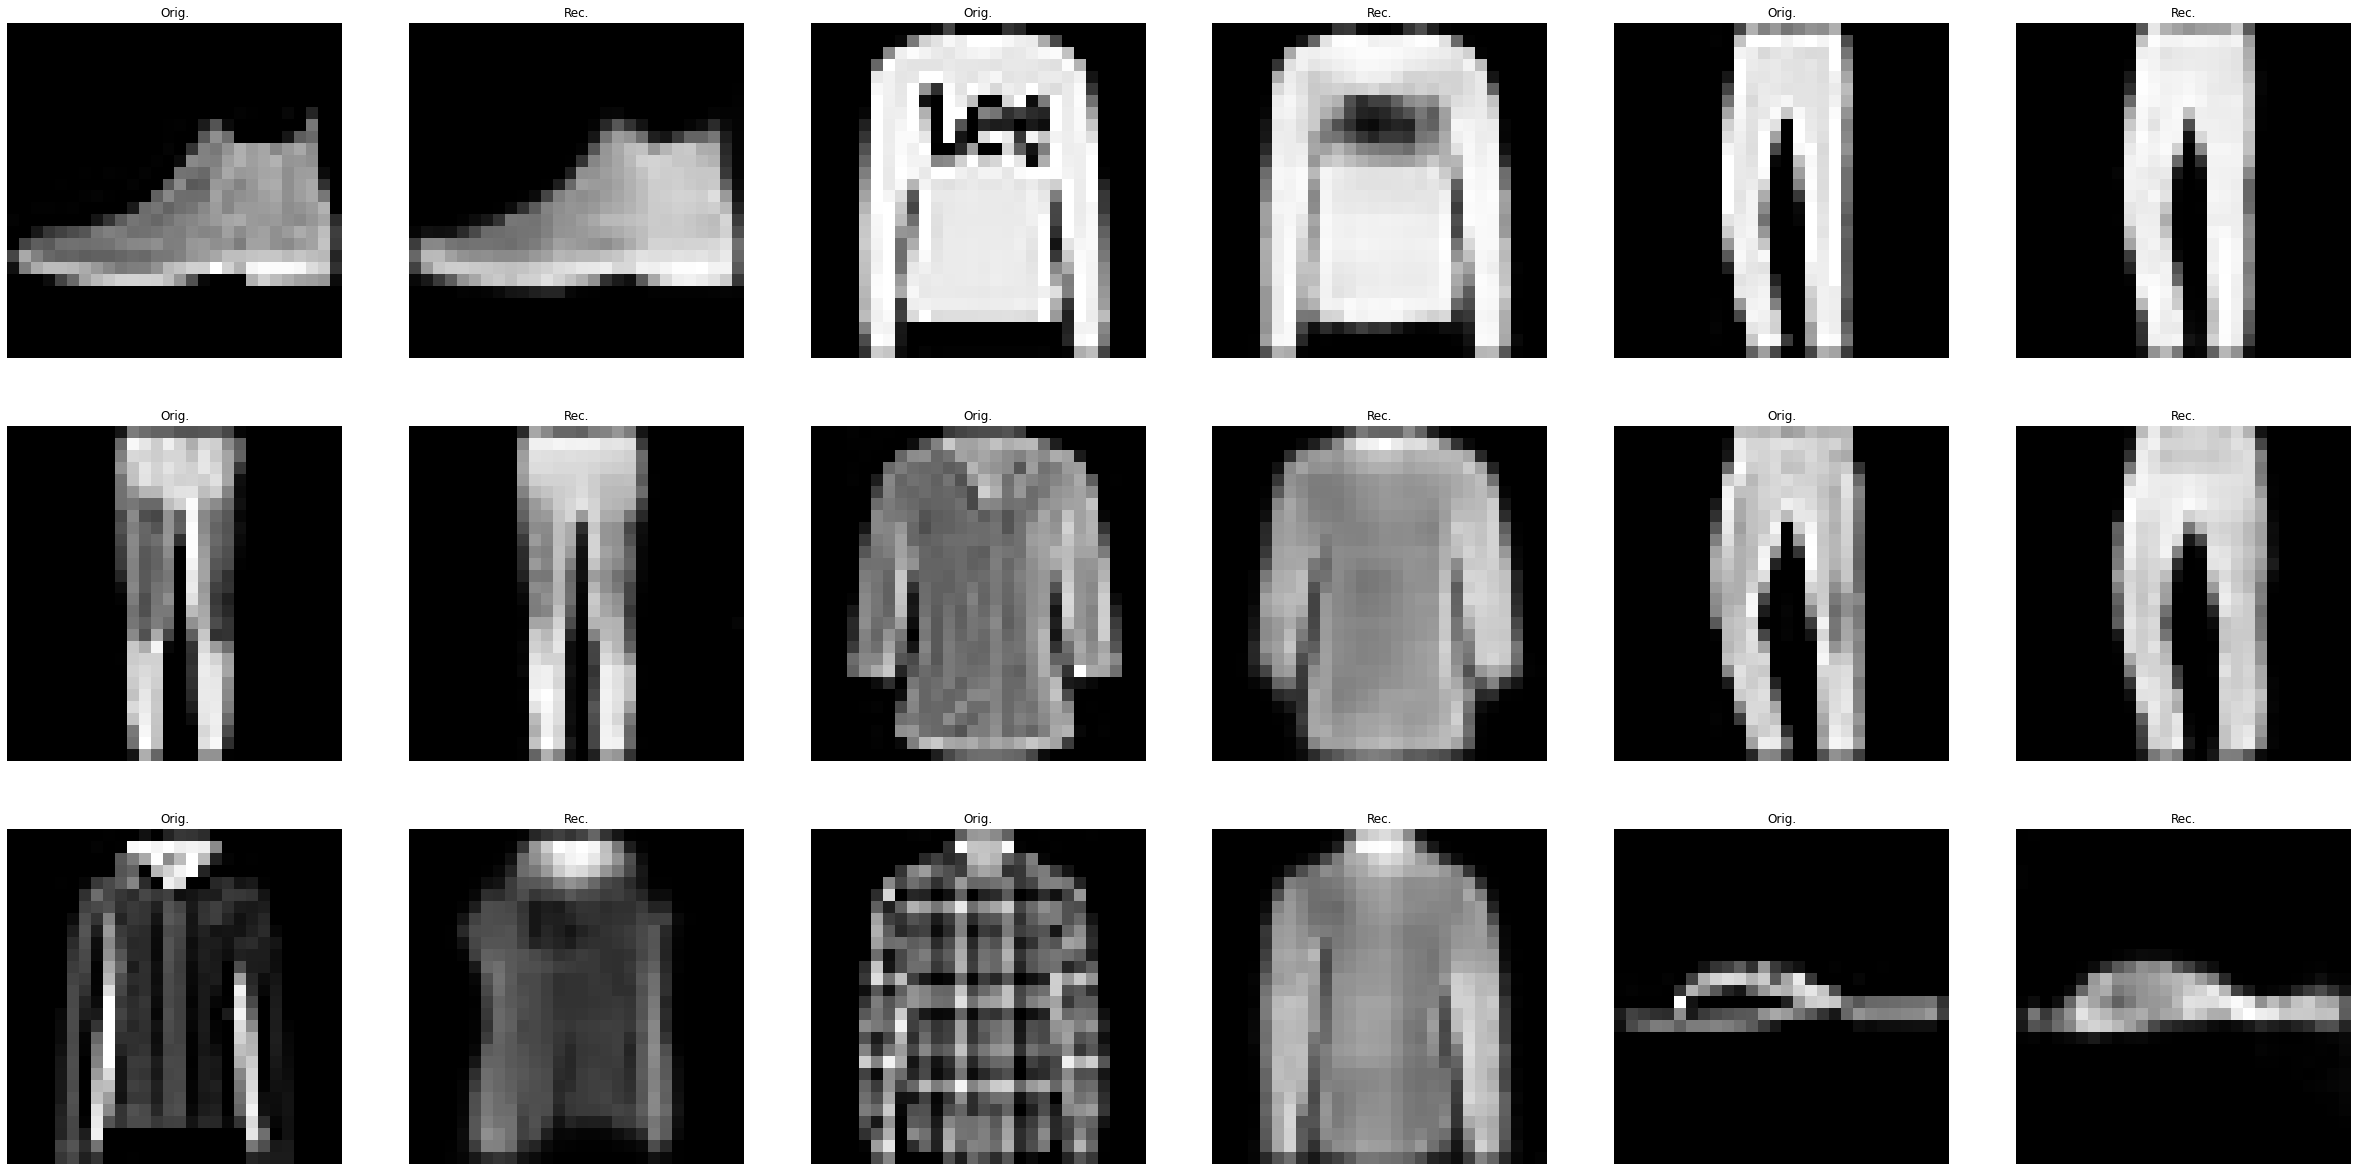

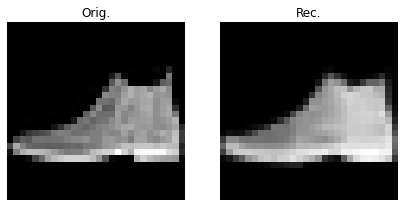

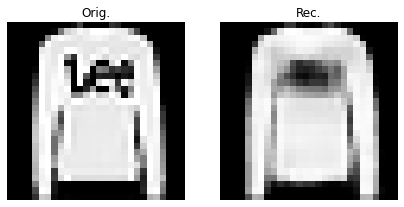

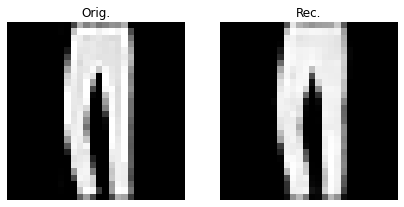

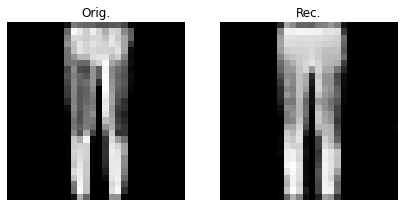

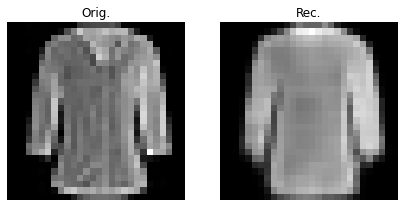

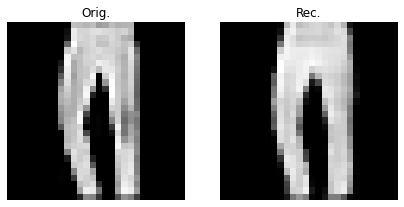

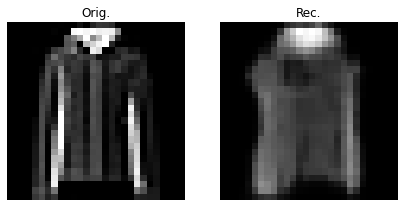

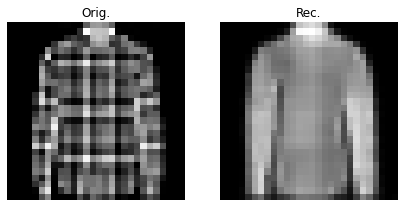

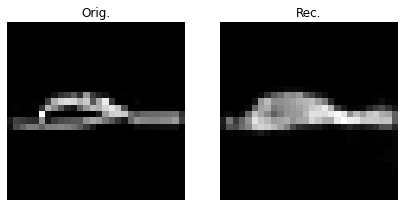

In [12]:
cae.plot_reconstructed_samples(test_dataset);

We notice that some images are almost perfectly reconstructed, while others lack some detail; for example the 'Lee' logo on the second image is fuzzier to the point of becoming unreadable, but apart from this the overall shape of the shirt is nicely reconstructed. More in general we notice that the edges are usually quite well preserved, while finer details become slightly smoothed; still we can be quite satisfied with this result, which tells us that the final test error is indeed low enough.  

The appendix contains the learning curves of this model and the 2D PCA/t-SNE projections of the learned representations of samples in the test dataset. From these last two plots (especially from the t-SNE one) we notice that the model has learned to cluster together images with the same label even without being shown the labels themselves; this means that the AutoEncoder was successfully able to learn some of the defining features of the dataset, and in particular how the image itself contains the information about which type of clothes it represents (even though it's not perfect, as clearly different categories frequently overlap in a way which makes no sense to a human expert). We also notice that the network was able to do this somewhat successful feature representation by representing each image with only 39 values, which is much less than the original $28\times 28 = 784$ pixels.

We'll later explore in more detail the relation between this clustering and the possibility of learning labels in an unsupervised way, by directly plotting the latent space of 2D autoencoders.

# Denoising autoencoder
## Introduction
We saw earlier how autoencoders architecture can be used to efficiently compress samples in a dataset, and how by doing so they can be used to reveal important underlying features. Another common application of this type of network is the *denoising task*, where a network is presented a corrupted sample and tasked with recovering the sample before noise was applied. An autoencoder capable of such a feat can be obtained by slightly tweaking the above procedure: we still ask the same architecture to minimize the reconstruction loss, only that this time it's the loss between a reconstructed noisy input and the pristine original version of it. This means that the network won't learn to compress a sample, but to remove noise from it, since we penalize it proportionally to how much the output of the noisy input differs from the uncorrupted one.

In [13]:
class Fashion_MNIST_dataset_noisy(Dataset): # same as the above but it accepts tensors as input instead of a file path
    def __init__(self, data, targets, transform): # data and targets attributes from the previous class
        self.data, self.targets = data, targets # this ensures we start from efficient and normalized data  
        self.transform  = transform    
        self.data_noisy = self.transform(self.data) # precomputing to speed up

    def __getitem__(self, index):
        img_tensor, label = self.data[index], self.targets[index]
        noisy_img_tensor  = self.data_noisy[index] # self.transform(img_tensor) # precomputing to speed up
        return img_tensor, noisy_img_tensor, label
    
    def __len__(self):
        return len(self.targets)

class AddGaussianNoise():
    def __init__(self, mean : float = 0., std : float = 1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor): # noisy_tensor = original_tensor + random_normal(mean, std)
        noisy_tensor = tensor + torch.randn(tensor.size(), device = tensor.device) * (self.std ** .5) + self.mean
        return torch.clamp(noisy_tensor, min = 0., max = 1.)
        
class AddSaltPepperNoise(): # pixels are corrupted with prob_to_be_corrupted; if corrupted they become 1 with p = prob_salt or 0 with p = 1-prob_salt
    def __init__(self, prob_to_be_corrupted: float = 0.05, prob_salt: float = 0.5):
        self.prob_to_be_corrupted = prob_to_be_corrupted
        self.prob_salt = prob_salt
    
    def __call__(self, tensor):
        affected_by_noise = torch.rand_like(tensor) < self.prob_to_be_corrupted
        salted = torch.rand_like(tensor) < self.prob_salt
        peppered = ~salted

        noisy_tensor = torch.clone(tensor)
        noisy_tensor[affected_by_noise & salted] = 1
        noisy_tensor[affected_by_noise & peppered] = 0
        return torch.clamp(noisy_tensor, min = 0., max = 1.)

class AddSpeckleNoise():
    def __init__(self, mean : float = 0., std : float = 1.):
        self.std = std
        self.mean = mean
    
    def __call__(self, tensor): # noisy_tensor = original_tensor + random_normal_filter(original_tensor)
        noisy_tensor = tensor + tensor * (torch.randn(tensor.size(), device = tensor.device) * (self.std ** 0.5) + self.mean)
        return torch.clamp(noisy_tensor, min = 0., max = 1.)

noise = torchvision.transforms.Compose([AddSpeckleNoise(), AddSaltPepperNoise(prob_salt = 0.5, prob_to_be_corrupted = 0.1), AddGaussianNoise(0.5, 0.3)])

# train_partial_dataset_tensor, val_dataset_tensor = train_dataset.train_val_split_tensors() # the same objects
train_partial_dataset_noisy, val_dataset_noisy = Fashion_MNIST_dataset_noisy(*train_partial_dataset_tensor, transform = noise), Fashion_MNIST_dataset_noisy(*val_dataset_tensor, transform = noise)
# from these new datasets we create dataloaders using the same function defined at the beginning
test_dataset_noisy = Fashion_MNIST_dataset_noisy(test_dataset.data, test_dataset.targets, transform = noise)

## Methods 
For simplicity we train a network using the same best hyperparameters found previously (which also guarantees good performance, to some extent). Training works as in the previous section, but this time inputs to the network are corrupted by stacking *gaussian noise*, *salt and pepper noise*, and *speckle noise*.
- Gaussian noise: values sampled from $\mathcal{N}(0.5,0.3)$ are randomly added to the tensor components.
- Salt and pepper noise: each pixel is corrupted with $5\%$ probability, and if corrupted it's turned to salt (= set equal to 1) with $50\%$ probability, or otherwise is turned to pepper (set to 0 wih $50\%$ probability).
- Speckle noise: we sum to the tensor a copy of itself convoluted with a filter whose entries are randomly sampled from a $\mathcal{N}(0,1)$.
Notice that every time we apply noise of some kind we clip the result to that each tensor component is again between 0 and 1, as to respect our pixel normalization.

Examples of these three types of noise are shown below (with gentler corruptions).

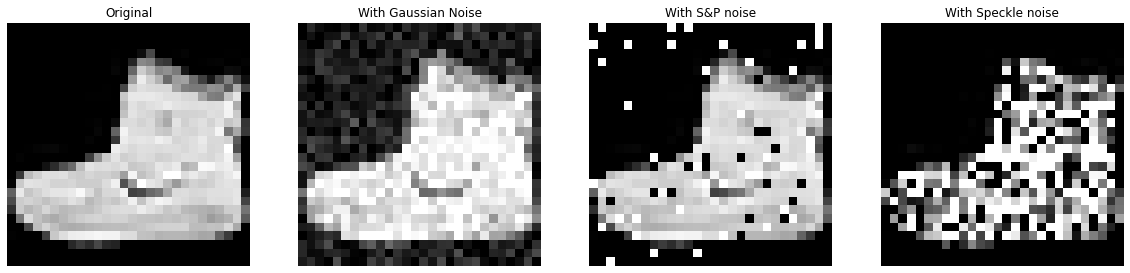

In [14]:
torch.random.manual_seed(1234)
torch.cuda.random.manual_seed(1234)

demo_img = train_dataset[0][0]
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))
ax[0].imshow(demo_img.cpu().squeeze(0).numpy(), cmap = 'gray')
ax[0].set_title('Original')

demo_img_gauss = AddGaussianNoise(0.1, 0.01)(demo_img)
ax[1].imshow(demo_img_gauss.cpu().squeeze(0).numpy(), cmap = 'gray')
ax[1].set_title('With Gaussian Noise')

demo_img_sp = AddSaltPepperNoise(prob_salt = 0.5, prob_to_be_corrupted = 0.1)(demo_img)
ax[2].imshow(demo_img_sp.cpu().squeeze(0).numpy(), cmap = 'gray')
ax[2].set_title('With S&P noise')

demo_img_speckle = AddSpeckleNoise()(demo_img)
ax[3].imshow(demo_img_speckle.cpu().squeeze(0).numpy(), cmap = 'gray')
ax[3].set_title('With Speckle noise')

for axx in ax.flatten():
    axx.axis('off')

In [15]:
class DenoisingConvAutoEncoder(ConvAutoEncoder):
    # same init, fit, plot, predict etc. function, since the overall network architecture is the same; we only need to change the training/validation steps + test_accuracy.
    def train_single_epoch(self, train_dataloader, verbose_single_epoch: bool = True): # function to be iterated inside the fit loop (no cv)
        self.train() # enable dropout etc.
        tr_err_single_epoch = 0

        loading = tqdm(train_dataloader) if verbose_single_epoch else train_dataloader
        for x_batch, x_noisy_batch, _ in loading: # ignore y_batch, we don't need the labels
            output = self(x_noisy_batch)
            loss   = self.loss_fn(output, x_batch) + self.reg() # we compare the reconstructed output with the original input
            self.optimizer.zero_grad() # reset gradients
            loss.backward() # backpropagation
            self.optimizer.step() # update weights
            tr_err_single_epoch += loss.detach().cpu().numpy() # save current training error
        
        tr_err_single_epoch /= len(train_dataloader) # len of a dataloader = n. of batches
        return tr_err_single_epoch

    @torch.no_grad()
    def val_single_epoch(self, val_dataloader):
        self.eval() # disable dropout etc.
        val_err_single_epoch = 0

        for x_batch, x_noisy_batch, _ in val_dataloader: # ignore y_batch, we don't need the labels
            output = self(x_noisy_batch)
            loss   = self.loss_fn(output, x_batch) # we compare the reconstructed output with the original input
            val_err_single_epoch += loss.detach().cpu().numpy()
        
        val_err_single_epoch /= len(val_dataloader)
        return val_err_single_epoch

    def test_accuracy(self, test_dataset_noisy):
        return float(self.loss_fn(self.predict(test_dataset_noisy.data_noisy), test_dataset_noisy.data))

    def plot_original_vs_reconstructed_sample(self, sample, noisy_sample, figsize = (7,7), return_array: bool = False):
        fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = figsize)

        img_rec   = self.predict(noisy_sample).cpu().detach().squeeze(0).squeeze(0).numpy() # one to eliminate N_samples, one to eliminate N_channels
        img       = sample.cpu().detach().squeeze(0).numpy()
        noisy_img = noisy_sample.cpu().detach().squeeze(0).numpy()

        ax[0].imshow(img, cmap = 'gray')
        ax[0].set_title('Orig.')
        ax[0].axis('off')
        ax[1].imshow(noisy_img, cmap = 'gray')
        ax[1].set_title('With noise')
        ax[1].axis('off')
        ax[2].imshow(img_rec, cmap = 'gray')
        ax[2].set_title('Rec.')
        ax[2].axis('off')

        if return_array:
            return img_rec # already a plottable array
        else:
            return fig, ax

    
    def plot_reconstructed_samples(self, dataset_noisy, nrows: int = 3, ncols: int = 2, figsize = (42, 21), seed: int = 1234):
        if seed is not None:
            torch.random.manual_seed(seed)
            torch.cuda.random.manual_seed(seed)
        
        indices = np.arange(nrows*ncols)
        idx = 0
        ncols = 3*ncols
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
        
        for i in range(nrows):
            for j in range(0, ncols, 3):
                img, noisy_img, _ = dataset_noisy[indices[idx]]
                img_rec = self.plot_original_vs_reconstructed_sample(img, noisy_img, return_array = True) # already a plottable array
                img = img.detach().cpu().squeeze(0).numpy()
                noisy_img = noisy_img.detach().cpu().squeeze(0).numpy()

                ax[i,j].imshow(img, cmap = 'gray')
                ax[i,j].set_title('Orig.')
                ax[i,j].axis('off')
                ax[i,j+1].imshow(noisy_img, cmap = 'gray')
                ax[i,j+1].set_title('With noise')
                ax[i,j+1].axis('off')
                ax[i,j+2].imshow(img_rec, cmap = 'gray')
                ax[i,j+2].set_title('Rec.')
                ax[i,j+2].axis('off')
                idx += 1

        return fig, ax

In [16]:
dcae = DenoisingConvAutoEncoder(**sample_hyperparameters(best_nn_seed)).cuda() # less max_n_iter --> less patience makes sense
# dcae.fit(train_partial_dataset_noisy, val_dataset_noisy, max_n_iter = 25, patience = 4) # if getitem transforms on the fly training is much slower; it can be brought to the same speed of the prev. training by preapplying the transformations in the class __init__.
dcae.load_state_dict(torch.load('./best_dcae/best_dcae.pth')) # precomputed
dcae.training_error_history = np.loadtxt('./best_dcae/best_dcae_th.csv')
dcae.val_error_history = np.loadtxt('./best_dcae/best_dcae_vh.csv')

In [17]:
print(f'Test error (denoising CAE) = {dcae.test_accuracy(test_dataset_noisy)}')

Test error (denoising CAE) = 0.026235107332468033


## Results
Our denoising convolutional autoencoder reaches a final MSE test error of about $0.02$, which is still quite small (even though it's a bit higher than the previous value; this makes sense, as this task is more difficult).

Actually this number becomes much more impressive than the original test error once we observe the denoising autoencoder in action:

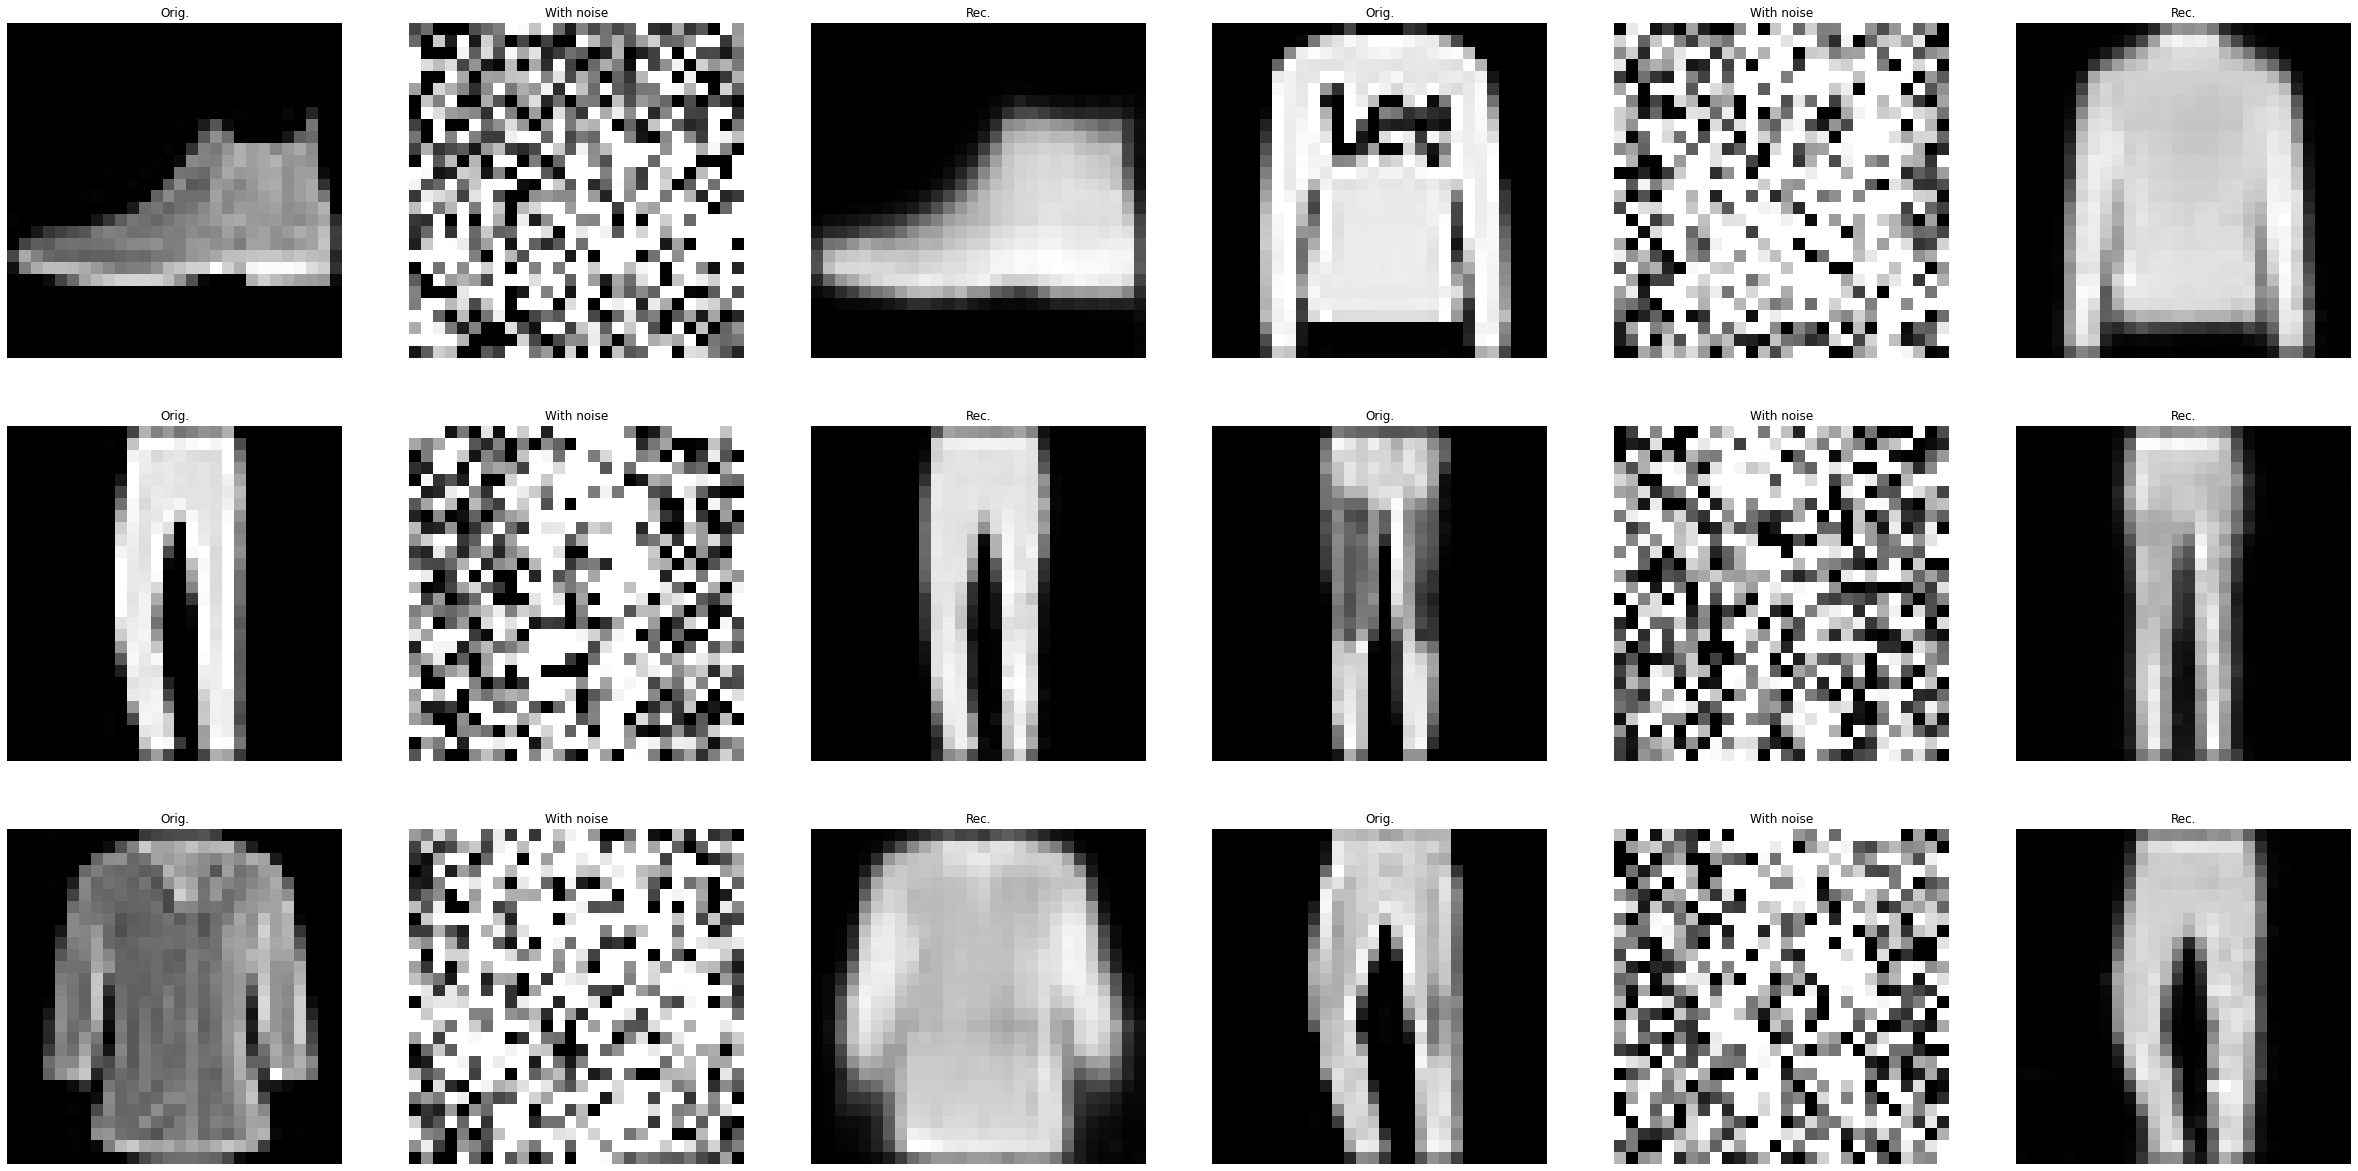

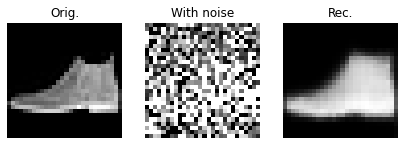

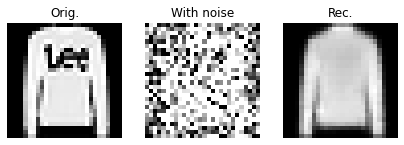

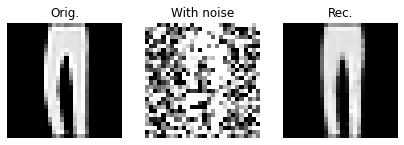

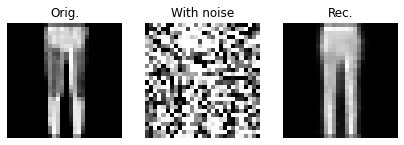

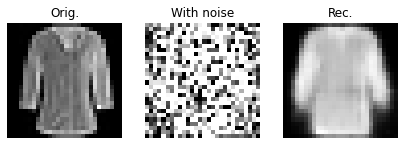

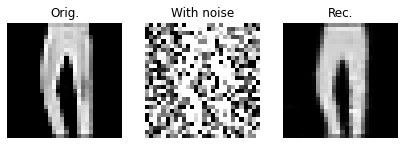

In [18]:
dcae.plot_reconstructed_samples(test_dataset_noisy);

Notice that each of these samples is corrupted to the point that even for a human expert it's impossible to tell what the original image was, and yet our network is capable of recovering the original image to an impressive degree. Even though this reconstruction is once again imperfect as some detail is lost (like the Lee logo in the second image, which this time instead of being smoothed out is completely removed) this result is still remarkable, as no human expert could be capable of recovering anything at all.

## Variational autoencoder
## Introduction
A *variational autoencoder* is a modified version of the autoencoder architecture, where some stochasticity is added to the model to guarantee improved interpretability and robustness-to-noise properties.

The main difference with the standard autoencoder architecture is that this time the encoder doesn't learn to directly output the latent representation of a sample, but rather the parameters of a distribution from which the latent representation is sampled; this essentially means that each sample is assigned a region inside the latent space instead of a single point. For this reason the training now consists of the network learning how to assign to each sample a probability distribution, which is forced to be as simple as possible via regularization; as we'll see below this guarantees improved interpretability and robustness-to-noise properties.

## Methods
For simplicity we only consider multivariate normal (gaussian) distributions in latent space; hence the encoder part of the architecture now outputs the mean and the variance of this distribution, whereas the decoder part is unchanged. Notice that for simplicity we assume that the covariance matrix is diagonal, so that the mean and variance vectors have the same length; this is equivalent to assuming uncorrelation of variables in latent space.

In particular the output of the convolutional part of the encoder (which is unchanged) is sent to two identical fully connected segments (with 2 layers: one with 288 units, the other with 64); one of these outputs the vector of means, while the other computes the logarithms of the variances. Once a sample is fed to the encoder means and variances are computed, and from these a latent space point is sampled according to the following equation:
\begin{equation}
  z = \mu + \varepsilon \sigma = \mu + \varepsilon \exp(0.5\log\sigma^2) \qquad \varepsilon \sim \mathcal{N}(0, I)
\end{equation}
This latent space point is then decoded as usual. Notice that the previous equation must necessarily be used since it's backpropagation-friendly: the whole non-differentiable stochastic contribution is contained in the $\varepsilon$ term, which is seen as a constant by the backpropagation algorithm.

The second main difference with the simple autoencoder is that to the `MSELoss` term we add the Kullback-Leiber divergence between the obtained $\mathcal{N}(\mu,\sigma)$ distribution and the standard normal $\mathcal{N}(0,I_d)$:
\begin{equation}
  L(x,\hat{x}) = ||x-\hat{x}||^2 + KL(\mathcal{N}(\mu,\sigma),\mathcal{N}(0,I)) = ||x-\hat{x}||^2 -\frac{1}{2}\sum_{i=1}^d (1+\log(\sigma_i^2)-\mu_i^2-\sigma_i^2)
\end{equation}
where the fact we chose gaussian distributions makes it so that we have a simple analytical formula for the KL term, the presence thereof will force the distribution to be as simple as possible - hence combating overfitting. Actually it's possible to show that this term isn't just a tool to improve learning, but a necessity; the rigorous way to prove this it by studying the bayesian interpretation of the variational autoencoder architecture, but the intuitive reason is that without it we can incur in pathological situations. Indeed it's possible that the learned variances become too small, and as a result the distribution is so centered around its mean that the variational autoencoder is no longer variational (i.e. it's returned to the basic version of the architecure); similarly with large means and variances it's possible that the distribution is centered very far from the sample, and yet it's so large that by chance the network happens to sample a point in the correct region - thus making learning too noisy.

Finally notice that we need to carefully normalize the loss. If the first term is a mean of squared errors then we need to divide the KL term by the number of samples in the batch, or leave the KL term as-is and replace the means squared error with the sum-of-squares error. If we don't do this the second term will on average be much larger, and the result will be that regularization is too strong; the network won't learn at all, and will always output the same symmetric white blob produced by the standard normal, irrespective of the input.

In [19]:
class VarAutoEncoder(nn.Module):
    def __init__(self, latent_space_dim: int, activation_function: str, optimizer: str,
                initial_lr: float, batch_size: int, dropout: float = None, l1_reg_strength: float = None, l2_reg_strength: float = None,
                loss_fn = nn.MSELoss(reduction = 'sum'), device = 'cuda'):
        super().__init__()
        self.latent_space_dim = latent_space_dim
        self.activation = getattr(nn, activation_function)()
        self.device = device
        self.dropout = dropout

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size = 3, stride = 2, padding = 1), #out = (8, 14, 14)
            self.activation,
            nn.Dropout2d(self.dropout) if dropout is not None else nn.Identity(),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1), #out = (16, 7, 7)
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 0), #out = (32, 3, 3)
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Flatten(start_dim = 1)
        )
        # 288 = 3*3*32
        self.decoder = nn.Sequential( 
            nn.Linear(self.latent_space_dim, 64),
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Linear(64, 288), 
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, output_padding=0),
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            self.activation,
            nn.Dropout2d(self.dropout) if dropout is not None else nn.Identity(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() #-> [0,1] output
        )

        self.avg = nn.Sequential( # Predicts the means of a MVN dist.
            nn.Linear(288, 64),
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Linear(64, self.latent_space_dim)
        )

        self.log_var = nn.Sequential( # Predicts the (log) variances of an uncorrelated MVN (i.e. log of cov. matrix diagonal)
            nn.Linear(288, 64), 
            self.activation,
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Linear(64, self.latent_space_dim)
        )

        if optimizer == 'SGD': # if optimizer is SGD we add Nesterov momentum with a 0.9 fairly standard value
            self.optimizer = torch.optim.SGD(params = self.parameters(), momentum = 0.9, nesterov = True, lr = initial_lr)
        else:
            self.optimizer = getattr(torch.optim, optimizer)(params = self.parameters(), lr = initial_lr)
        
        self.batch_size = batch_size
        self.loss_fn = loss_fn
        self.l1_reg_strength = l1_reg_strength
        self.l2_reg_strength = l2_reg_strength

        if l1_reg_strength is None and l2_reg_strength is None:
            self.reg = lambda: torch.tensor([0], dtype = float, requires_grad = True).to(self.device)
        if l1_reg_strength is not None:
            self.reg = lambda: (sum(((w.abs()).sum() for w in self.parameters()))*self.l1_reg_strength).to(self.device)
        if l2_reg_strength is not None:
            self.reg = lambda: (sum(((w**2).sum() for w in self.parameters()))*self.l2_reg_strength).to(self.device)

    def sample_in_latent_space(self, mu, log_var): # sampling from MVN in latent space with provided mean and variances
        sigma = torch.exp(0.5 * log_var) #log_var is log(variance) = log(sigma**2) = 2 * log(sigma)
        return mu + torch.randn_like(mu) * sigma
        #Var(aX) = a**2 Var(X), so we need to multiply pred_sqrt_var = sigma (square root of the variance) by the standard normal distribution

    def forward(self, x):
        internal_repr  = self.encoder(x) # conv. part --> produces the internal representation
        pred_means     = self.avg(internal_repr) # linear part 1 --> predicts means
        pred_log_var   = self.log_var(internal_repr) # linear part 2 --> predicts variances
        sample         = self.sample_in_latent_space(mu = pred_means, log_var = pred_log_var) # sample in latent space
        decoded_sample = self.decoder(sample) # decoder --> produces final output
        
        return decoded_sample, pred_means, pred_log_var # we need to pass means and vars forward too, since they're needed to compute the KL div. term in the loss

    def train_single_epoch(self, train_dataloader, verbose_single_epoch: bool = True): # function to be iterated inside the fit loop (no cv)
        self.train() # enable dropout etc.
        tr_err_single_epoch = 0

        loading = tqdm(train_dataloader) if verbose_single_epoch else train_dataloader
        for x_batch, _ in loading: # ignore y_batch, we don't need the labels
            output, mu, log_var = self(x_batch)
            loss                = self.loss_fn(output, x_batch) + self.reg() - 0.5 * torch.sum(1. + log_var - mu**2 - torch.exp(log_var))
            loss /= len(x_batch)
            self.optimizer.zero_grad() # reset gradients
            loss.backward() # backpropagation
            self.optimizer.step() # update weights
            tr_err_single_epoch += loss.detach().cpu().numpy() # save current training error
        
        tr_err_single_epoch /= len(train_dataloader) # len of a dataloader = n. of batches
        return tr_err_single_epoch

    @torch.no_grad()
    def val_single_epoch(self, val_dataloader):
        self.eval() # disable dropout etc.
        val_err_single_epoch = 0

        for x_batch, _ in val_dataloader: # ignore y_batch, we don't need the labels
            output, mu, log_var   = self(x_batch)
            loss                  = nn.MSELoss()(output, x_batch) # we compare the reconstructed output with the original input
            val_err_single_epoch += loss.detach().cpu().numpy()
        
        val_err_single_epoch /= len(val_dataloader)
        return val_err_single_epoch

    def fit(self, train_partial_dataset, val_dataset, max_n_iter: int = 25, min_n_iter: int = 3, patience: int = 4, tol: float = 0.0001, seed: int = 1234, verbose: bool = True, num_workers: int = 0):
        if seed is not None: # default seed to ensure reproducibility
            torch.random.manual_seed(seed)

        training_dataloader, validation_dataloader = create_train_val_dataloaders(train_partial_dataset, val_dataset, batch_size = self.batch_size, num_workers = num_workers) # dependent on self.batch_size

        self.training_error_history, self.val_error_history = np.zeros(max_n_iter), np.zeros(max_n_iter) # no CV --> no average over dataloaders --> we have a single value to use as an estimate of tr./val. errors
        self.best_val_error = np.Inf
        patience_counter = 0

        loading = trange(max_n_iter) # if verbose else range(max_n_iter) # useful toggle during training/debugging
        for epoch in loading:
            if verbose:
                print(f'Training {epoch=}') # useful to track training
            tr_err  = self.training_error_history[epoch] = self.train_single_epoch(train_dataloader = training_dataloader)
            val_err = self.val_error_history[epoch] = self.val_single_epoch(val_dataloader = validation_dataloader)
            if verbose:
                print(f'{epoch=}: {tr_err=}, {val_err=}') # useful to track training

            if epoch > min_n_iter:
                if val_err > self.best_val_error + tol:
                    patience_counter += 1
                else:
                    self.best_val_error = val_err
                    patience_counter = 0
                if patience_counter > patience:
                    break
        n_executed_epochs = epoch + 1 # + 1 to go from 0, N-1 (python) to 1, N (human readable) counting scheme 
        if n_executed_epochs < max_n_iter:
            self.best_val_error_epoch = n_executed_epochs - patience_counter
        else:
            self.best_val_error_epoch = max_n_iter - patience_counter

    @torch.no_grad()
    def predict(self, sample):
        self.eval()
        if sample.shape == torch.Size([1, 28, 28]): # a single sample
            output = self(sample.unsqueeze(0))[0] # the forward pass computes means and variances too, but here we only want the reconstructed samples
        else:
            output = self(sample)[0]
        return output

    def test_accuracy(self, test_dataset):
        return float(nn.MSELoss()(self.predict(test_dataset.data), test_dataset.data))

    def plot_original_vs_reconstructed_sample(self, sample, figsize = (7,7), return_array: bool = False):
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = figsize)
        img = sample
        img_rec = self.predict(img).cpu().detach().squeeze(0).squeeze(0).numpy() # one to eliminate N_samples, one to eliminate N_channels
        img = img.cpu().detach().squeeze(0).numpy()

        ax[0].imshow(img, cmap = 'gray')
        ax[0].set_title('Orig.')
        ax[0].axis('off')
        ax[1].imshow(img_rec, cmap = 'gray')
        ax[1].set_title('Rec.')
        ax[1].axis('off')

        if return_array:
            return img_rec
        else:
            return fig, ax

    
    def plot_reconstructed_samples(self, dataset, nrows: int = 3, ncols: int = 3, figsize = (42, 21)):
        indices = np.arange(nrows*ncols)
        idx = 0
        ncols = 2*ncols
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
        
        for i in range(nrows):
            for j in range(0, ncols, 2):
                img = dataset.data[indices[idx]]
                img_rec = self.plot_original_vs_reconstructed_sample(img, return_array = True)
                img = img.detach().cpu().squeeze(0).numpy()
                ax[i,j].imshow(img, cmap = 'gray')
                ax[i,j].set_title('Orig.')
                ax[i,j].axis('off')
                ax[i,j+1].imshow(img_rec, cmap = 'gray')
                ax[i,j+1].set_title('Rec.')
                ax[i,j+1].axis('off')
                idx += 1

        return fig, ax

In [20]:
vae = VarAutoEncoder(**sample_hyperparameters(best_nn_seed)).cuda()
# vae.fit(train_partial_dataset, val_dataset)
vae.load_state_dict(torch.load('./best_vae/vae.pth'))
vae.training_error_history = np.loadtxt('./best_vae/vae_th.csv')
vae.val_error_history = np.loadtxt('./best_vae/vae_vh.csv')

In [21]:
print(f'Test error (variational CAE): {vae.test_accuracy(test_dataset)}')

Test error (variational CAE): 0.023366346955299377


## Results
The network is trained for 25 epochs + early stopping with the same best hyperparameters found at the beginning. The final test error is $\sim 0.02$, the same as the denoising autoencoder and therefore slightly worse than the original autoencoder - but still good nonetheless. We can confirm that the performance is "a bit worse but not too much" by visualizing a few reconstructed samples:

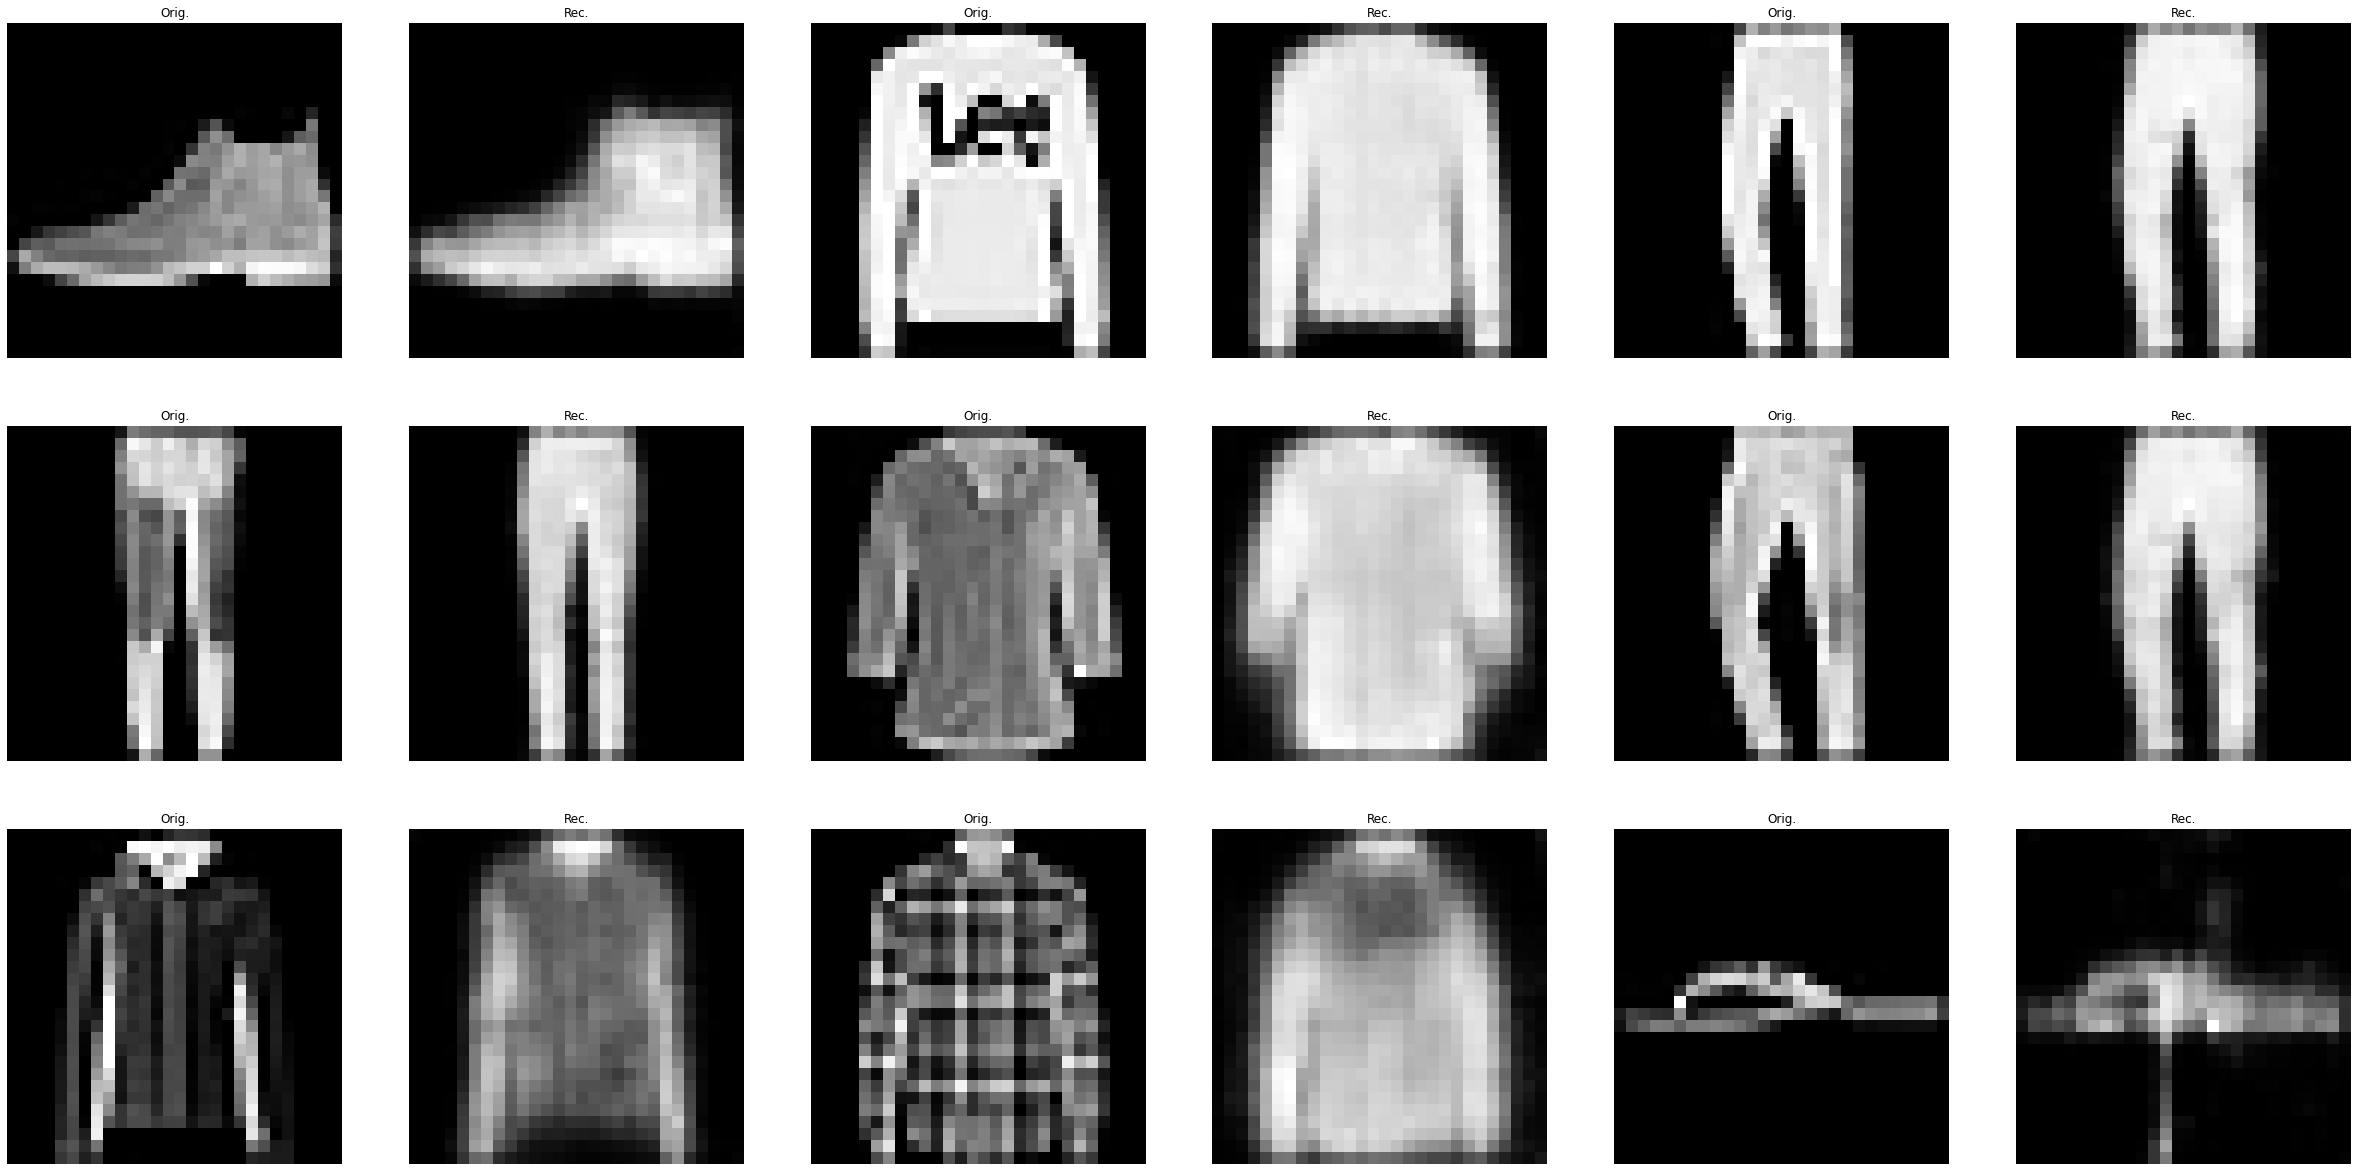

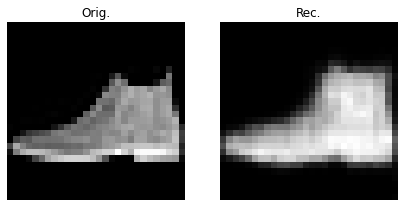

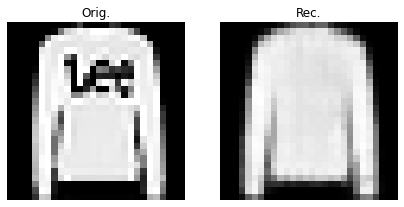

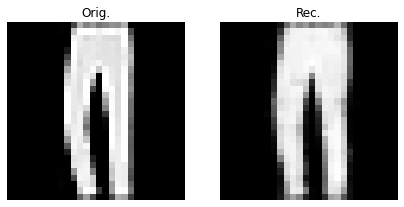

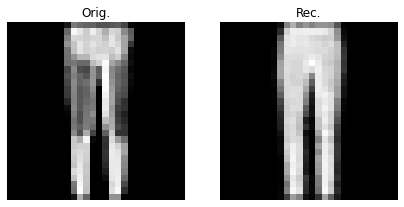

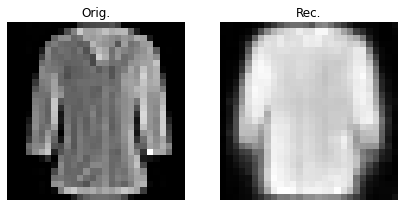

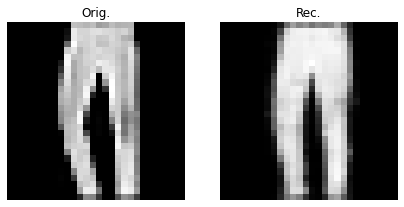

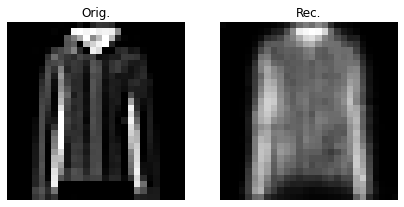

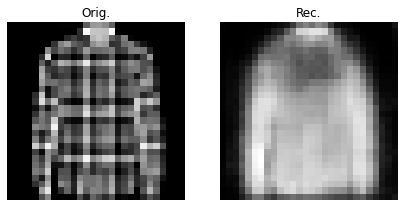

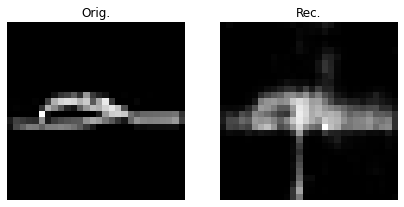

In [22]:
vae.plot_reconstructed_samples(test_dataset);

If we consider for example the second image we notice that the Lee logo has completely disappeared (whereas it was simply smoothed by the original architecture), and similarly for the other samples (e.g. like the shirt stripes in the second to last image); and yet the reconstruction is still good, since most of the times the the original shape/edges are preserved.

It now seems that switching to a variational architecture was a bad idea; we can show that we actually gained something as follows. Even though the final representations are a bit lower qualities they are more resistant to noise: a small change in the input is mapped to a small change in the latent space, and therefore our network learned a manifold in which we can smoothly transition between samples of different classes. Indeed notice what happens when we decode latent space points along the line connecting the representations of two dataset samples:

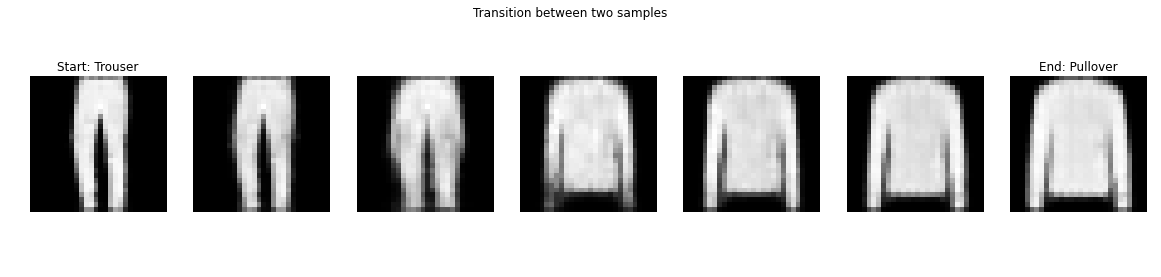

In [23]:
zalando = pd.read_csv('./fashion_mnist_dict.csv')

vae.eval()

start_img, y1 = test_dataset[2]
end_img, y2 = test_dataset[1]

y1, y2 = int(y1.cpu()), int(y2.cpu())

with torch.no_grad():
    start_pos = vae.avg(vae.encoder(start_img.unsqueeze(0))).data.cpu().numpy().flatten()
    end_pos = vae.avg(vae.encoder(end_img.unsqueeze(0))).data.cpu().numpy().flatten()
    
steps = 2 + 5
line = np.linspace(0, 1, 7)
points = [start_pos + val * (end_pos - start_pos) for val in line]


fig, axs = plt.subplots(1, steps, figsize=(20, 4))

for i, (ax, point) in enumerate(zip(axs.ravel(), points)):
    with torch.no_grad():
        img = vae.decoder(torch.tensor(point).cuda().unsqueeze(0)).cpu()
    
    if i == 0:
        ax.set_title(f"Start: {(zalando[zalando.label == y1].description).to_numpy()[0]}")
    if i == steps-1:
        ax.set_title(f"End: {(zalando[zalando.label == y2].description).to_numpy()[0]}")
        
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.axis('off')
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.suptitle('Transition between two samples');

# plt.tight_layout()
# fig.savefig("Plots/vae_transition.pdf", transparent=True, bbox_inches='tight')

We notice that a trouser image becomes a pullover by connecting the legs, then by inserting sleeves. This arguably is also what a human expert would do to gradually transform an image into another; this means that this "smooth input changes $\to$ smooth output changes" property actually implies better interpretability properties, as the learned manifold is more about features like shape/color than about clustering images with the same labels. This point is better illustrated below, where we compare the direct latent space representations of the validation set when using either a convolutional or a variational autoencoder architecture (same hyperparameters, but with $d=2$):

In [24]:
s = sample_hyperparameters(best_nn_seed)
s.update({'latent_space_dim':2})
cae2d = ConvAutoEncoder(**s).cuda()
# cae2d.fit(train_partial_dataset, val_dataset, max_n_iter = 25, patience = 4)
cae2d.load_state_dict(torch.load('./ae_2d/cae2d.pth'))
cae2d.training_error_history = np.loadtxt('./ae_2d/cae2d_th.csv')
cae2d.val_error_history = np.loadtxt('./ae_2d/cae2d_vh.csv')

In [25]:
vae2d = VarAutoEncoder(**s).cuda()
# vae2d.fit(train_partial_dataset, val_dataset, max_n_iter = 25, patience = 4)
vae2d.load_state_dict(torch.load('./ae_2d/vae2d.pth'))
vae2d.training_error_history = np.loadtxt('./ae_2d/vae2d_th.csv')
vae2d.val_error_history = np.loadtxt('./ae_2d/vae2d_vh.csv')

In [26]:
# torch.save(cae2d.state_dict(), './ae_2d/cae2d.pth')
# np.savetxt('./ae_2d/cae2d_th.csv', cae2d.training_error_history)
# np.savetxt('./ae_2d/cae2d_vh.csv', cae2d.val_error_history)

In [27]:
zalando.description.to_list()

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

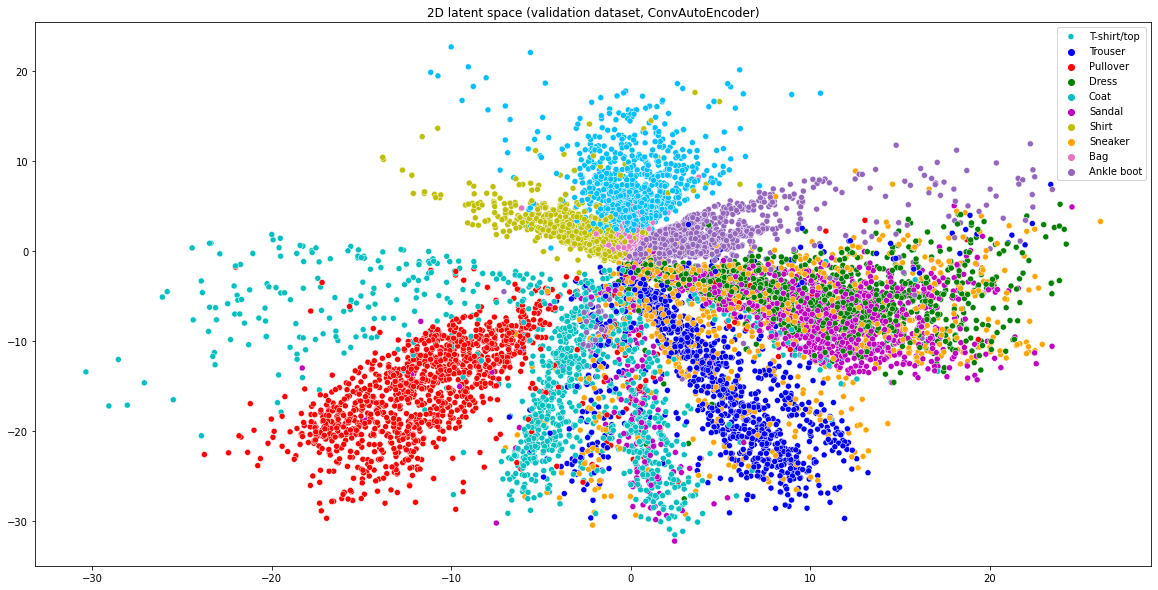

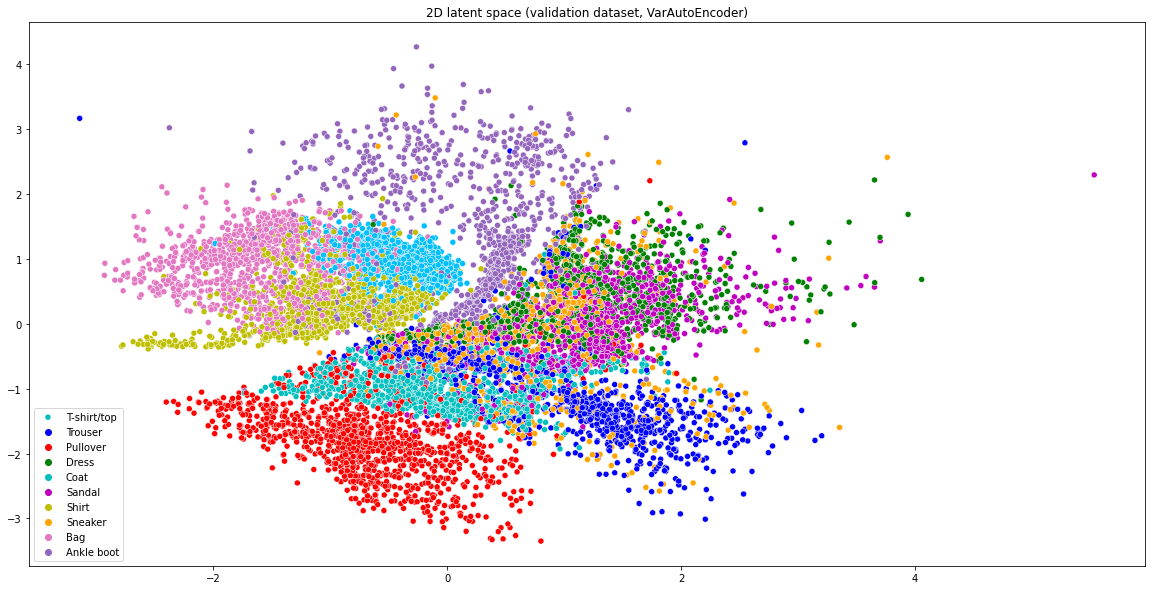

In [28]:
def plot_2d_latent_space(model, dataset, dataset_name: str, figsize = (20, 10)):
    labels = dataset.targets.cpu().detach().numpy()
    colors_dict = {0:'b', 1:'r', 2:'g', 3:'c', 4:'m', 5:'y', 6:'orange', 7:'tab:pink', 8:'tab:purple', 9:'deepskyblue'}
    colors_list = [colors_dict[i] for i in labels]
    model_type = model.__class__.__name__

    if model_type == 'VarAutoEncoder':
        encoded_samples = model.avg(model.encoder(dataset.data)).detach().cpu().numpy()
    elif model_type == 'ConvAutoEncoder':
        encoded_samples = model.encoder(dataset.data).detach().cpu().numpy()
    fig, ax = plt.subplots(figsize = figsize)
    sns.scatterplot(x = encoded_samples[:,0], y = encoded_samples[:,1], hue = labels, palette = colors_dict, ax = ax, legend = 'auto')
    ax.set_title(f'2D latent space ({dataset_name} dataset, {model_type})')
    ax.legend(labels = zalando.description.to_list())
    return fig, ax

plot_2d_latent_space(cae2d, val_dataset, 'validation');
plot_2d_latent_space(vae2d, val_dataset, 'validation');

The 2D convolutional autoencoder has learned to cluster together samples of the same label; as we noted in the PCA/t-SNE representations of a more complex architecture this means that the network has partially learned the labels by itself even without being shown the labels themselves.

The 2D variational autoencoder instead has learned to cluster together images with similar *features*, instead of images with the same *label*; indeed notice how pullover, t-shirt and dress images are close to each other (which means that the network is focusing on image features, as these clothes have similar shapes) - and the same is true e.g. for ankle boot, sandal and sneaker categories.

To recap: a standard autoencoder indirectly learns to cluster images that represent the same kind of clothes, whereas the variational autoencoder learns to cluster images that are visually similar.

# Transfer learning
## Introduction
Another interesting application of autoencoders is that they can be used to speed up convergence of traditional supervised learning classifiers. In particular it's possible to use transfer learning to train a convolutional classifier; this means that in a standard "convolutional + f.c." architecture we only train the fully connected layers, whereas the convolutional part is "stolen" from a pretrained encoder. This drastically reduces the number of parameters to train, hence boosting convergence speed; we now show that it also allows to reach comparable performance to standard training procedures.

## Methods
The convolutional part of the encoder of the first convolutional autoencoder is now attached to two fully connected layers (128 and 10 neurons respectively) separated by a `ReLU` activation for simplicity. During training gradients are disabled for the convolutional part, i.e. we freeze the first part of the network.

In [29]:
class TLClassifier(nn.Module):
    def __init__(self, seed: int, autoencoder_path: str):
        super().__init__()
        self.conv_autoencoder = ConvAutoEncoder(**sample_hyperparameters(seed))
        self.conv_autoencoder.load_state_dict(torch.load(autoencoder_path))
        # disabling gradients so that this part of the network is not updated during training
        for p in self.conv_autoencoder.parameters():
            p.requires_grad = False
        self.encoder = self.conv_autoencoder.encoder
        self.latent_space_dim = self.conv_autoencoder.latent_space_dim
        self.dropout = self.conv_autoencoder.dropout

        if self.dropout is not None and 0 < self.dropout < 1:
            # self.dropout = dropout
            self.dropout_layer = nn.Dropout(p = dropout)
        else:
            # self.dropout = None
            self.dropout_layer = nn.Identity()

        self.trainable_part = nn.Sequential(
            nn.Linear(self.latent_space_dim, 128),
            self.dropout_layer,
            nn.ReLU(),
            nn.Linear(128, 10),
            self.dropout_layer # a simple architecture to speed up convergence (one of the benefits of TL)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.initial_lr = sample_hyperparameters(seed)['initial_lr'] # self.conv_autoencoder.initial_lr
        self.optimizer = torch.optim.Adam(self.parameters(), lr = self.initial_lr)
        self.batch_size = self.conv_autoencoder.batch_size
        self.l1_reg_strength = self.conv_autoencoder.l1_reg_strength
        self.l2_reg_strength = self.conv_autoencoder.l2_reg_strength
        self.device = self.conv_autoencoder.device

        if self.l1_reg_strength is None and self.l2_reg_strength is None:
            self.reg = lambda: torch.tensor([0], dtype = float, requires_grad = True).to(self.device)
        if self.l1_reg_strength is not None:
            self.reg = lambda: (sum(((w.abs()).sum() for w in self.parameters()))*self.l1_reg_strength).to(self.device)
        if self.l2_reg_strength is not None:
            self.reg = lambda: (sum(((w**2).sum() for w in self.parameters()))*self.l2_reg_strength).to(self.device) 

    def forward(self, x):
        return self.trainable_part(self.encoder(x))

    def train_single_epoch(self, train_dataloader):
        self.train() # enable dropout etc.
        tr_err_single_epoch = 0

        for x_batch, y_batch in tqdm(train_dataloader):
            output = self(x_batch)
            loss   = self.loss_fn(output, y_batch) + self.reg()
            self.optimizer.zero_grad() # reset gradients
            loss.backward() # backpropagation
            self.optimizer.step() # update weights
            tr_err_single_epoch += loss.detach().cpu().numpy() # save current training error
        
        tr_err_single_epoch /= len(train_dataloader) # len of a dataloader = n. of batches
        return tr_err_single_epoch

    @torch.no_grad()
    def val_single_epoch(self, val_dataloader):
        self.eval() # disable dropout etc.
        val_err_single_epoch = 0

        for x_batch, y_batch in val_dataloader:
            output = self(x_batch)
            loss   = self.loss_fn(output, y_batch)
            val_err_single_epoch += loss.detach().cpu().numpy()
        
        val_err_single_epoch /= len(val_dataloader)
        return val_err_single_epoch

    def fit(self, train_partial_dataset, val_dataset, max_n_iter: int = 50, min_n_iter: int = 3, patience: int = 10, tol: float = 0.01, seed: int = 1234, verbose: bool = True, num_workers: int = 0):
        if seed is not None: # default seed to ensure reproducibility
            torch.random.manual_seed(seed)

        training_dataloader, validation_dataloader = create_train_val_dataloaders(train_partial_dataset, val_dataset, batch_size = self.batch_size, num_workers = num_workers) # dependent on self.batch_size

        self.training_error_history, self.val_error_history = np.zeros(max_n_iter), np.zeros(max_n_iter) # no CV --> no average over dataloaders --> we have a single value to use as an estimate of tr./val. errors
        self.best_val_error = np.Inf
        patience_counter = 0

        loading = trange(max_n_iter) # if verbose else range(max_n_iter) # useful toggle during training/debugging
        for epoch in loading:
            if verbose:
                print(f'Training {epoch=}') # useful to track training
            tr_err  = self.training_error_history[epoch] = self.train_single_epoch(train_dataloader = training_dataloader)
            val_err = self.val_error_history[epoch] = self.val_single_epoch(val_dataloader = validation_dataloader)
            if verbose:
                print(f'{epoch=}: {tr_err=}, {val_err=}') # useful to track training

            if epoch > min_n_iter:
                if val_err > self.best_val_error + tol:
                    patience_counter += 1
                else:
                    self.best_val_error = val_err
                    patience_counter = 0
                if patience_counter > patience:
                    break
        n_executed_epochs = epoch + 1 # + 1 to go from 0, N-1 (python) to 1, N (human readable) counting scheme 
        if n_executed_epochs < max_n_iter:
            self.best_val_error_epoch = n_executed_epochs - patience_counter
        else:
            self.best_val_error_epoch = max_n_iter - patience_counter

    def predict(self, x):
        self.eval()
        return self(x).argmax(1) # look for the max along columns since each row is a different sample
        # this effectively eliminates the need for a softmax activation in the output layer when predicting labels

    def test_accuracy(self, test_dataset):
        y_pred = self.predict(test_dataset.data)
        y_true = test_dataset.targets
        correct_pred_frac = y_pred.eq(y_true).float().mean().cpu().detach()
        return float(correct_pred_frac)

    def plot_learning_curves(self, smooth: int = None, figsize: tuple = (10,5)):
        if smooth is not None:
            tr_h  = np.convolve(self.training_error_history, np.ones(smooth)/smooth, mode = 'valid') # fir filter L-point running average to smooth our signal if needed
            val_h = np.convolve(self.val_error_history, np.ones(smooth)/smooth, mode = 'valid')
        else:
            tr_h  = self.training_error_history
            val_h = self.val_error_history
        
        tr_h, val_h = tr_h[tr_h > 0], val_h[val_h > 0] # so that the plot looks better when early stopping occurs

        epochs = np.arange(len(tr_h))
        fig, ax = plt.subplots(figsize = figsize)
        ax.plot(epochs, tr_h,  label = 'training error',   c = 'r', linewidth = 3)
        ax.plot(epochs, val_h, label = 'validation error', c = 'b', linewidth = 3)
        ax.set_yscale('log')
        ax.set_xlabel('epoch')
        ax.set_ylabel('error')
        ax.legend()
        ax.set_title(f'Learning curves (tr./val.) (total training duration = {len(tr_h)} epochs)')

        return fig, ax

In [30]:
tl = TLClassifier(best_nn_seed, 'best_cae/cae.pth').cuda()
# tl.fit(train_partial_dataset, val_dataset)
tl.load_state_dict(torch.load('./tl/tl.pth'))
tl.training_error_history = np.loadtxt('./tl/tl_th.csv')
tl.val_error_history = np.loadtxt('./tl/tl_vh.csv')

In [31]:
print(f'Test accuracy (transfer learning)  : {tl.test_accuracy(test_dataset):.2%}')
print(f'Test accuracy (supervised learning): 89.85%')

Test accuracy (transfer learning)  : 87.23%
Test accuracy (supervised learning): 89.85%


## Results
We train the classifier for 25 epochs with early stopping. Convergence is reached in a small fraction of the time needed for the HW1 classifier, both in the sense that it took only a few minutes and in the sense that the error stabilizes in less than 20 epochs (as we can see in the learning curves in the appendix). At the same time the final test error is still quite good, since we lost less than $3\%$ test accuracy. We conclude that by sacrificing very little performance we're able to train a successful classifier with a fraction of the resources needed otherwise; still if optimal performance is desired the standard approach is still the way to go.

# Appendix

Explained variance: [0.29723203 0.20647477]


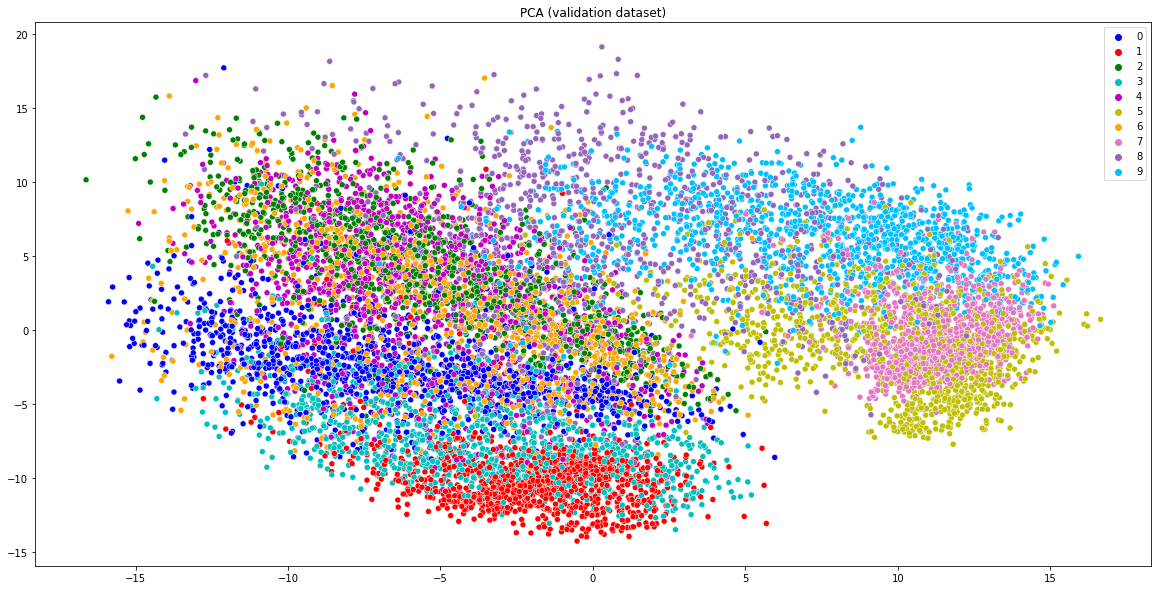

In [32]:
cae.plot_pca(val_dataset, 'validation');

2D PCA projection of the 39 dimensional representations of samples in the validation set, as learned by the convolutional autoencoder with the best parameters featured in the first part.

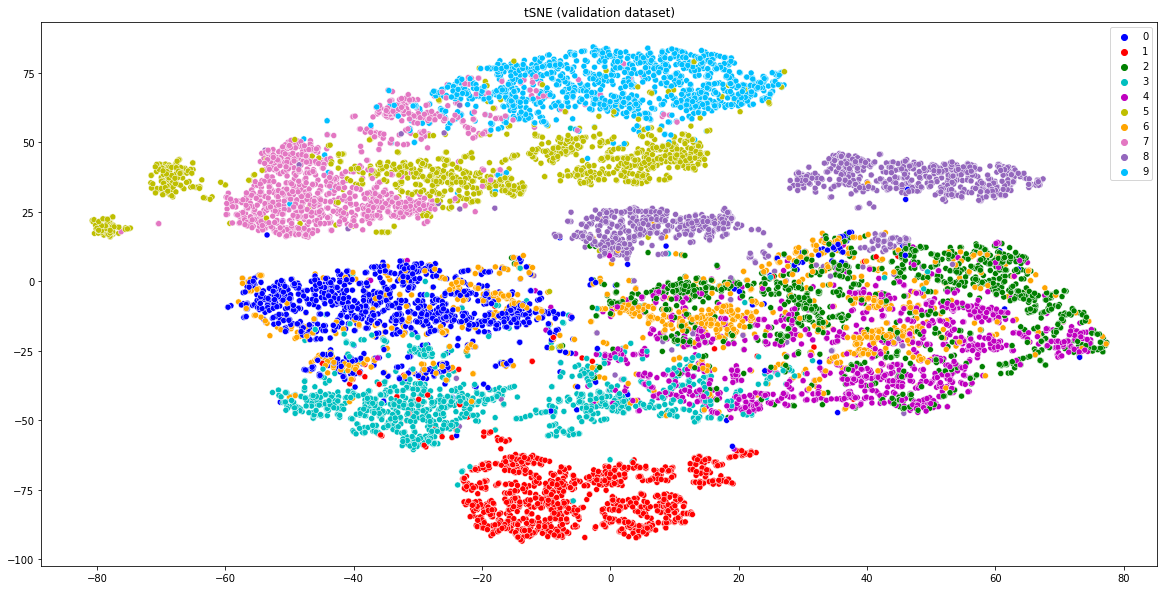

In [33]:
cae.plot_tsne(val_dataset, 'validation');

2D tSNE projection of the 39 dimensional representations of samples in the validation set, as learned by the convolutional autoencoder with the best parameters featured in the first part. The learned clustering of same-label samples is even more evident (w.r.t. the PCA projection).

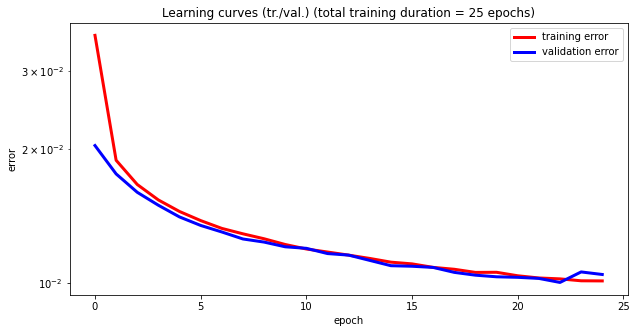

In [34]:
cae.plot_learning_curves();

Learning curve of the best convolutional autoencoder, featured in the first part. Convergence is quite quick, requiring only a few minutes and about 25 epochs (with early stopping).

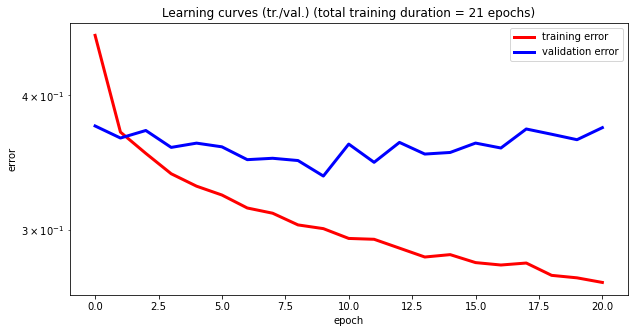

In [35]:
tl.plot_learning_curves();

Learning curves of the transfer learning classifier. Notice that training is much faster than the HW1 classifier, since it converges less than 20 epochs while at the same time being computationally much faster (only a few minutes).